In [1]:
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import pickle
# fig_dir = "./Figures/"
plt.rcParams["figure.facecolor"] = "w"

In [2]:
all_conflicts = pd.read_csv("/home/jyotika/2-arm-bandit-task/Data/processed_data/Y_maze/data_with_animal_ids/all_experiments_df_with_DTs.csv")

In [3]:
No_conflict_low_volatility = all_conflicts.loc[(all_conflicts["conflict"]=="No")&(all_conflicts["volatility"]=="Low") & (all_conflicts["condition"].str.contains("Control")) & (all_conflicts["animal_id"]!=10)] 

In [4]:
num_c_array = np.arange(2,10) # numbers of potential states
folds = 5 # number of dataset splits, lower folds give better result, maybe because of large contiguous blocks to train


In [5]:
data_dir = "../../Data/"
fig_dir = "../../Figures/"

In [6]:
# Functions
def remove_outliers(data):
    # Remove outliers
    q1 = np.percentile(data.dec_time.values,25)
    q3 = np.percentile(data.dec_time.values,75)
    iqr = q3 - q1
    low_limit = q1 - 1.5*iqr
    high_limit = q3 + 1.5*iqr
    
    return data.loc[(data['dec_time']>low_limit)&(data['dec_time']<high_limit)]

def concatenate_all_sessions(data):
    block_change = []
    dec_times = []
    optimal_action = []

    for session in data['session'].unique():
        #pulling out each out session of the mouse 
        df_session = data.loc[(data['session']) == session]
        df_session.reset_index(drop=True, inplace=True)

        # shifting decision time measurements down by 1 - this was not done in the processed dataset
        df_session['dec_time_robust_scaled'] = df_session.dec_time_robust_scaled.shift(1)

        # calculating decision time median + median absolute deviation per session
        #dt_med = df_session['dec_time'].median()
        #dt_mad = (df_session['dec_time'] - df_session['dec_time'].median()).abs().median()

        for index, row in df_session.iterrows():
            if index > 0:
                # checking if the mouse stayed/switched actions based on whether they were rewarded previously 
                # if they were rewarded and stayed, or if they were unrewarded and switched, this counted as the optimal action
                if row['chosen_action'] == df_session.loc[int(index) - 1, 'chosen_action'] and df_session.loc[int(index) - 1, 'rewarded_code'] == 1:
                    optimal_action.append(1)
                elif row['chosen_action'] != df_session.loc[int(index) - 1, 'chosen_action'] and df_session.loc[int(index) - 1, 'rewarded_code'] == 0:
                    optimal_action.append(1)
                else:
                    optimal_action.append(0)

                # if row['chosen_action'] == df_session.loc[int(index) - 1, 'chosen_action']:
                #     optimal_action.append(1)
                # else: 
                #     optimal_action.append(0) 

                # checking to see if a block change happened
                if row['block'] == df_session.loc[int(index) - 1, 'block']:
                    block_change.append(0)
                else:
                    block_change.append(1)

                # normalizing the decision times based on median + median absolute deviation
                #dec_times.append((row['dec_time'] - dt_med)/dt_mad)
                dec_times.append(row['dec_time_robust_scaled'])
            else: 
                # default values to denote the beginning of a session
                optimal_action.append(-1)
                block_change.append(1)
                dec_times.append(row['dec_time_robust_scaled'])    
    
    return block_change, dec_times,optimal_action

def calculate_moving_average(data):
    optimal_action_mv = []
    reward_mv = []
    dec_times_mv = []
    
    for session in mouse_indiv_wo_outliers['session'].unique():
        df_session = mouse_indiv_wo_outliers.loc[(mouse_indiv_wo_outliers['session']) == session]
        df_session.reset_index(drop=True, inplace=True)

        oa = df_session['optimal_action'].ewm(span=4).mean()
        rew = df_session['rewarded_code'].ewm(span=4).mean()
        dts = df_session['dec_time_robust_scaled'].ewm(span=4).mean()

          
        optimal_action_mv.extend(oa.tolist())
        reward_mv.extend(rew.tolist())    
        dec_times_mv.extend(dts.tolist())
        
    return optimal_action_mv, reward_mv, dec_times_mv
        
def find_ideal_states(data,num_c_array):    
    bic_df = pd.DataFrame()
    score_df = pd.DataFrame()
    for i,state in enumerate(num_c_array):
        for k in np.random.choice(np.arange(1,9999999),5):
            print("num_states",state)
            #for j,split in enumerate(dataset_split):
            for j, (train_index, test_index) in enumerate(kf.split(data)):
                print("split",j)
                # splitting into train and validate based on the previous splitting of the data
                X_validate = data[test_index]
                X_train = data[train_index]#np.concatenate([k for l,k in enumerate(dataset_split) if l != j])

                model = GaussianHMM(covariance_type='full', n_components=state,tol=0.001,n_iter=300,random_state=k)#params='ste', init_params='ste')
                try:
                    model.fit(X_train) # training the model
                except ValueError:
                    continue
                bic = model.bic(X_validate) # finding the BIC based on validation data
                score = model.score(X_validate) # finding the score based on validation data

                score_df = pd.concat([score_df,pd.DataFrame({'num_states':[state],'fold':[j],'score':[score],'seed':[k]})],ignore_index=True)
                bic_df = pd.concat([bic_df,pd.DataFrame({'num_states':[state],'fold':[j],'BIC':[bic],'seed':[k]})],ignore_index=True)

    return bic_df, score_df

1


/tmp/ipykernel_661667/3955555459.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_indiv_wo_outliers["dec_time_robust_scaled"] =scale.fit_transform(mouse_indiv_wo_outliers.dec_time.values.reshape(-1,1))
/tmp/ipykernel_661667/1853900206.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session['dec_time_robust_scaled'] = df_session.dec_time_robust_scaled.shift(1)
/tmp/ipykernel_661667/3955555459.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0


Model is not converging.  Current: 3382.497403572883 is not greater than 3382.4978450667872. Delta is -0.0004414939044181665


split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2


Model is not converging.  Current: 3622.43250925229 is not greater than 3622.437158792892. Delta is -0.004649540602258639


split 3
split 4


Model is not converging.  Current: 3849.1159960653363 is not greater than 3849.12092051563. Delta is -0.004924450293856353


num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 3594.1536095956076 is not greater than 3594.1537020118026. Delta is -9.241619500244269e-05


num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 5
split 0
split 1
split 2
split 3
split 4
num_states 5
split 0
split 1
split 2
split 3


Model is not converging.  Current: 4862.138415516287 is not greater than 4862.148939836173. Delta is -0.010524319885917066


split 4
num_states 5
split 0
split 1


Model is not converging.  Current: 4669.489603956712 is not greater than 4669.49089686376. Delta is -0.0012929070480822702


split 2
split 3


Model is not converging.  Current: 4862.308782914062 is not greater than 4862.325916398905. Delta is -0.01713348484281596


split 4
num_states 5
split 0
split 1
split 2
split 3
split 4
num_states 5
split 0
split 1
split 2
split 3
split 4
num_states 6
split 0
split 1
split 2
split 3
split 4
num_states 6
split 0
split 1


Model is not converging.  Current: 5233.174128989795 is not greater than 5233.174731791476. Delta is -0.0006028016814525472


split 2


Model is not converging.  Current: 5649.618247206285 is not greater than 5649.618909570276. Delta is -0.0006623639910685597


split 3
split 4


Model is not converging.  Current: 4499.299402705489 is not greater than 4499.2995883968315. Delta is -0.00018569134226709139


num_states 6
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 4762.12238652409 is not greater than 4762.127619796752. Delta is -0.0052332726618260494


num_states 6
split 0
split 1
split 2
split 3
split 4
num_states 6
split 0
split 1
split 2


Model is not converging.  Current: 4909.8667778259005 is not greater than 4909.881410980168. Delta is -0.014633154267357895


split 3
split 4
num_states 7
split 0
split 1
split 2


Model is not converging.  Current: 5858.728990505095 is not greater than 5858.737048569875. Delta is -0.008058064780016139


split 3
split 4
num_states 7
split 0


Model is not converging.  Current: 6667.225475175472 is not greater than 6667.237260419647. Delta is -0.01178524417537119


split 1
split 2


Model is not converging.  Current: 5994.815791898007 is not greater than 5994.8158231504585. Delta is -3.125245166302193e-05


split 3


Model is not converging.  Current: 6668.062067949656 is not greater than 6668.075330505911. Delta is -0.013262556254630908


split 4
num_states 7
split 0
split 1
split 2


Model is not converging.  Current: 6324.806550818798 is not greater than 6324.825510850713. Delta is -0.018960031914502906


split 3
split 4
num_states 7
split 0
split 1


Model is not converging.  Current: 6086.035526929848 is not greater than 6086.047826547421. Delta is -0.012299617573262367


split 2


Model is not converging.  Current: 5954.121754014933 is not greater than 5954.123064168813. Delta is -0.0013101538797855028


split 3
split 4
num_states 7
split 0
split 1
split 2
split 3
split 4
num_states 8
split 0
split 1
split 2


Model is not converging.  Current: 6730.212709283416 is not greater than 6730.212783881639. Delta is -7.459822245436953e-05


split 3
split 4
num_states 8
split 0


Model is not converging.  Current: 7121.159901292703 is not greater than 7121.167501207685. Delta is -0.007599914982165501


split 1


Model is not converging.  Current: 6450.176927375815 is not greater than 6450.185539874585. Delta is -0.008612498770162347


split 2


Model is not converging.  Current: 6285.295268610141 is not greater than 6285.29553720012. Delta is -0.0002685899789867108


split 3


Model is not converging.  Current: 6728.491709819489 is not greater than 6728.507683663817. Delta is -0.015973844328073028


split 4
num_states 8
split 0
split 1
split 2
split 3
split 4
num_states 8
split 0


Model is not converging.  Current: 7104.012607411974 is not greater than 7104.03128387068. Delta is -0.018676458706067933


split 1
split 2
split 3
split 4


Model is not converging.  Current: 6960.149771167484 is not greater than 6960.15575692586. Delta is -0.0059857583764824085


num_states 8
split 0


Model is not converging.  Current: 6729.743835692344 is not greater than 6729.783920387248. Delta is -0.04008469490418065


split 1
split 2


Model is not converging.  Current: 6700.521935026363 is not greater than 6700.5254006774685. Delta is -0.0034656511052162386


split 3
split 4
num_states 9
split 0


Model is not converging.  Current: 7466.076197442942 is not greater than 7466.221583411732. Delta is -0.14538596878992394


split 1
split 2


Model is not converging.  Current: 7320.492302370678 is not greater than 7320.492305191628. Delta is -2.820949703163933e-06


split 3


Model is not converging.  Current: 7608.396526286763 is not greater than 7608.400266787015. Delta is -0.0037405002522064024


split 4


Model is not converging.  Current: 7024.843460252385 is not greater than 7024.8483427097. Delta is -0.004882457315034117


num_states 9
split 0
split 1
split 2
split 3


Model is not converging.  Current: 7491.66081029727 is not greater than 7491.666635303958. Delta is -0.005825006688610301


split 4


Model is not converging.  Current: 7181.967145564248 is not greater than 7182.003205946936. Delta is -0.03606038268753764


num_states 9
split 0
split 1
split 2


Model is not converging.  Current: 7152.21157039597 is not greater than 7152.21181897844. Delta is -0.00024858246979420073


split 3


Model is not converging.  Current: 7348.642922028486 is not greater than 7348.651731670962. Delta is -0.008809642476080626


split 4
num_states 9
split 0


Model is not converging.  Current: 7723.054696405347 is not greater than 7723.0621711945405. Delta is -0.007474789193111064


split 1


Model is not converging.  Current: 6842.090569659064 is not greater than 6842.095868116978. Delta is -0.005298457913340826


split 2


Model is not converging.  Current: 7165.616387015863 is not greater than 7165.638343331973. Delta is -0.02195631610993587


split 3
split 4


Model is not converging.  Current: 7335.97510924008 is not greater than 7335.979859023841. Delta is -0.0047497837604169035


num_states 9
split 0


Model is not converging.  Current: 7445.545907737377 is not greater than 7445.548255179278. Delta is -0.0023474419012927683


split 1
split 2
split 3


Model is not converging.  Current: 7490.519215509194 is not greater than 7490.548435848435. Delta is -0.029220339240964677


split 4
calc_bic
Means: [[-0.12748237  0.43831063  0.20179222]
 [ 0.18487754  0.99462902  0.99503038]
 [-0.04413988  0.64726239  0.50771259]
 [ 0.12999721  0.80883432  0.85216574]
 [ 0.03944307  0.67685286  0.70484149]
 [-0.06728441  0.4583942   0.45798837]
 [ 0.24708931  0.94043226  0.94975544]]
2


/tmp/ipykernel_661667/3955555459.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_indiv_wo_outliers["dec_time_robust_scaled"] =scale.fit_transform(mouse_indiv_wo_outliers.dec_time.values.reshape(-1,1))
/tmp/ipykernel_661667/1853900206.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session['dec_time_robust_scaled'] = df_session.dec_time_robust_scaled.shift(1)
/tmp/ipykernel_661667/3955555459.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0


Model is not converging.  Current: 1304.382215196882 is not greater than 1304.3825655525973. Delta is -0.00035035571522712416


split 1


Model is not converging.  Current: 1546.8845452958064 is not greater than 1546.8944730433386. Delta is -0.00992774753217418


split 2
split 3


Model is not converging.  Current: 1275.2813185225718 is not greater than 1275.307692344105. Delta is -0.02637382153307044


split 4
num_states 3
split 0


Model is not converging.  Current: 1509.0931152233786 is not greater than 1509.274044187785. Delta is -0.1809289644063483


split 1


Model is not converging.  Current: 1546.8922088385084 is not greater than 1546.8939272139087. Delta is -0.0017183754002871865


split 2
split 3


Model is not converging.  Current: 1275.29803950142 is not greater than 1275.3242485587755. Delta is -0.02620905735557244


split 4
num_states 3
split 0
split 1


Model is not converging.  Current: 1387.44138961859 is not greater than 1387.4417055540746. Delta is -0.0003159354846502538


split 2
split 3


Model is not converging.  Current: 1275.2982966888812 is not greater than 1275.3088106406983. Delta is -0.010513951817074485


split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0


Model is not converging.  Current: 1117.647607644501 is not greater than 1117.693271582854. Delta is -0.04566393835307281


split 1


Model is not converging.  Current: 1546.8864843854853 is not greater than 1546.8949952258629. Delta is -0.008510840377539353


split 2
split 3


Model is not converging.  Current: 1266.4320668307164 is not greater than 1266.7444678089128. Delta is -0.31240097819636503


split 4
num_states 4
split 0


Model is not converging.  Current: 2100.585826755286 is not greater than 2100.58608707019. Delta is -0.000260314904153347


split 1


Model is not converging.  Current: 1444.7540546872433 is not greater than 1444.7959750078637. Delta is -0.04192032062042017


split 2


Model is not converging.  Current: 1927.8075882003416 is not greater than 1927.8104984507936. Delta is -0.0029102504520324146


split 3
split 4


Model is not converging.  Current: 2144.2444368698884 is not greater than 2144.3190942913507. Delta is -0.0746574214622342


num_states 4
split 0
split 1


Model is not converging.  Current: 1823.9517445061394 is not greater than 1823.9825605916496. Delta is -0.03081608551019599


split 2


Model is not converging.  Current: 1703.909024881506 is not greater than 1703.9238052736098. Delta is -0.014780392103830309


split 3


Model is not converging.  Current: 1781.9133773074554 is not greater than 1781.9161959651108. Delta is -0.0028186576553252962


split 4


Model is not converging.  Current: 2308.575262632278 is not greater than 2308.5832878050733. Delta is -0.008025172795441904


num_states 4
split 0


Model is not converging.  Current: 1695.0920434819027 is not greater than 1695.0962779240615. Delta is -0.004234442158804086


split 1


Model is not converging.  Current: 1906.4525800621423 is not greater than 1906.4662787491714. Delta is -0.013698687029091161


split 2


Model is not converging.  Current: 2189.2868496810524 is not greater than 2189.2980805036946. Delta is -0.011230822642119165


split 3


Model is not converging.  Current: 1973.2474883395262 is not greater than 1973.3105543236315. Delta is -0.06306598410537845


split 4


Model is not converging.  Current: 2308.733219310236 is not greater than 2308.773194548642. Delta is -0.0399752384059866


num_states 4
split 0


Model is not converging.  Current: 2092.825957522436 is not greater than 2092.8326819375698. Delta is -0.006724415133703587


split 1


Model is not converging.  Current: 1906.4421912252074 is not greater than 1906.4636442018643. Delta is -0.021452976656973988


split 2


Model is not converging.  Current: 2189.3942823910534 is not greater than 2189.4164493719986. Delta is -0.02216698094525782


split 3
split 4


Model is not converging.  Current: 2308.3473687320516 is not greater than 2308.349789140385. Delta is -0.002420408333364321


num_states 4
split 0


Model is not converging.  Current: 2099.4631408133014 is not greater than 2099.464354668124. Delta is -0.0012138548227085266


split 1
split 2


Model is not converging.  Current: 2189.644418286295 is not greater than 2189.656872464614. Delta is -0.012454178318876075


split 3


Model is not converging.  Current: 1973.181555836562 is not greater than 1973.2855433329387. Delta is -0.10398749637670335


split 4


Model is not converging.  Current: 2308.4308969494477 is not greater than 2308.432446991973. Delta is -0.0015500425251957495


num_states 5
split 0


Model is not converging.  Current: 2487.753352989549 is not greater than 2487.7938606890643. Delta is -0.040507699515274


split 1


Model is not converging.  Current: 2266.8861910071123 is not greater than 2266.923770367287. Delta is -0.037579360174731846


split 2


Model is not converging.  Current: 2567.87899546048 is not greater than 2567.889827904929. Delta is -0.010832444449079048


split 3


Model is not converging.  Current: 2361.1334139530254 is not greater than 2361.134422999853. Delta is -0.0010090468276757747


split 4
num_states 5
split 0


Model is not converging.  Current: 830.013332700611 is not greater than 831.9089757810713. Delta is -1.8956430804602178


split 1
split 2
split 3


Model is not converging.  Current: 2293.2417547761847 is not greater than 2293.2520340263554. Delta is -0.010279250170697196


split 4
num_states 5
split 0
split 1
split 2


Model is not converging.  Current: 2578.581974316963 is not greater than 2578.616228185363. Delta is -0.034253868399900966


split 3


Model is not converging.  Current: 2315.506269105381 is not greater than 2315.507211199854. Delta is -0.000942094472975441


split 4
num_states 5
split 0
split 1
split 2


Model is not converging.  Current: 2531.881395312357 is not greater than 2531.8838706521356. Delta is -0.002475339778357011


split 3
split 4
num_states 5
split 0
split 1


Model is not converging.  Current: 2416.9433958313098 is not greater than 2416.950527970777. Delta is -0.007132139467103116


split 2


Model is not converging.  Current: 2228.1731947641815 is not greater than 2228.1829928761867. Delta is -0.009798112005228177


split 3


Model is not converging.  Current: 2394.0993262384677 is not greater than 2394.1240795837034. Delta is -0.024753345235694724


split 4
num_states 6
split 0


Model is not converging.  Current: 2714.7929525862605 is not greater than 2714.8159133790914. Delta is -0.02296079283087238


split 1
split 2
split 3


Model is not converging.  Current: 2398.1123409128522 is not greater than 2398.394407200368. Delta is -0.2820662875155904


split 4
num_states 6
split 0


Model is not converging.  Current: 1933.9716370758597 is not greater than 1933.9719687365287. Delta is -0.00033166066896228585


split 1
split 2


Model is not converging.  Current: 2739.0207370474495 is not greater than 2739.0272360759077. Delta is -0.006499028458165412


split 3


Model is not converging.  Current: 2521.944123303124 is not greater than 2522.1504339573876. Delta is -0.20631065426368878


split 4


Model is not converging.  Current: 3046.732471903684 is not greater than 3046.755588038766. Delta is -0.023116135081636457


num_states 6
split 0


Model is not converging.  Current: 2525.9747190354683 is not greater than 2525.9824070647987. Delta is -0.0076880293304384395


split 1


Model is not converging.  Current: 2582.4080156719992 is not greater than 2582.4152643417096. Delta is -0.00724866971040683


split 2


Model is not converging.  Current: 2747.072415929535 is not greater than 2747.216161508537. Delta is -0.14374557900191576


split 3
split 4


Model is not converging.  Current: 2476.213894465627 is not greater than 2476.215420252321. Delta is -0.0015257866939464293


num_states 6
split 0
split 1
split 2


Model is not converging.  Current: 2885.1942671725787 is not greater than 2885.310695554461. Delta is -0.1164283818820877


split 3


Model is not converging.  Current: 2425.582763140411 is not greater than 2425.8650740513194. Delta is -0.28231091090856353


split 4


Model is not converging.  Current: 2878.7878328666084 is not greater than 2878.788256558362. Delta is -0.0004236917534399254


num_states 6
split 0


Model is not converging.  Current: 2731.4089501405388 is not greater than 2731.4162703599677. Delta is -0.007320219428947894


split 1


Model is not converging.  Current: 2180.6258892462656 is not greater than 2747.724303189621. Delta is -567.0984139433554


split 2


Model is not converging.  Current: 2947.311906805668 is not greater than 2947.3139150620063. Delta is -0.002008256338285719


split 3
split 4


Model is not converging.  Current: 3058.1377343633217 is not greater than 3058.3709604293795. Delta is -0.23322606605779583


num_states 7
split 0


Model is not converging.  Current: 2564.890848461848 is not greater than 2565.0129215686425. Delta is -0.12207310679468719


split 1


Model is not converging.  Current: 2587.135020030298 is not greater than 3309.873658145528. Delta is -722.7386381152301


split 2
split 3


Model is not converging.  Current: 2885.645554884852 is not greater than 2885.6803747873823. Delta is -0.034819902530216496


split 4


Model is not converging.  Current: 3100.3976789784206 is not greater than 3100.5043322033553. Delta is -0.1066532249346892


num_states 7
split 0
split 1


Model is not converging.  Current: 2523.148511723356 is not greater than 3111.059395101558. Delta is -587.910883378202


split 2


Model is not converging.  Current: 2335.6923725163315 is not greater than 2335.711854606977. Delta is -0.019482090645396966


split 3
split 4
num_states 7
split 0


Model is not converging.  Current: 3000.5961227800212 is not greater than 3000.7346434712995. Delta is -0.13852069127824507


split 1


Model is not converging.  Current: 2566.144326954022 is not greater than 2566.1526015231807. Delta is -0.008274569158857048


split 2
split 3
split 4


Model is not converging.  Current: 2914.591142757961 is not greater than 2914.5923991960126. Delta is -0.0012564380517687823


num_states 7
split 0


Model is not converging.  Current: 2840.3548602441374 is not greater than 2840.355365105722. Delta is -0.0005048615844316373


split 1
split 2


Model is not converging.  Current: 3103.0807042209476 is not greater than 3103.0996577295737. Delta is -0.018953508626054827


split 3
split 4


Model is not converging.  Current: 2915.426681935953 is not greater than 2915.47180284737. Delta is -0.045120911416688614


num_states 7
split 0


Model is not converging.  Current: 2906.9230261721677 is not greater than 2907.2105506324065. Delta is -0.28752446023872835


split 1
split 2


Model is not converging.  Current: 2818.9699013338104 is not greater than 2819.0152074081107. Delta is -0.04530607430024247


split 3


Model is not converging.  Current: 2922.783193664615 is not greater than 2922.8860094999413. Delta is -0.10281583532650984


split 4


Model is not converging.  Current: 3254.7567723725992 is not greater than 3254.808324866352. Delta is -0.051552493752751616


num_states 8
split 0


Model is not converging.  Current: 2768.9098498463673 is not greater than 2768.911338762678. Delta is -0.0014889163107909553


split 1


Model is not converging.  Current: 2666.550507977722 is not greater than 3426.2174611001806. Delta is -759.6669531224584


split 2


Model is not converging.  Current: 3299.7679477164593 is not greater than 3299.7938053060743. Delta is -0.025857589615043253


split 3
split 4
num_states 8
split 0
split 1


Model is not converging.  Current: 2614.515179565762 is not greater than 3210.4742490282106. Delta is -595.9590694624485


split 2
split 3


Model is not converging.  Current: 2438.9568531140126 is not greater than 2952.754260808827. Delta is -513.7974076948144


split 4
num_states 8
split 0


Model is not converging.  Current: 2839.781912503856 is not greater than 2839.7869189319076. Delta is -0.005006428051729017


split 1
split 2


Model is not converging.  Current: 2929.0899797781876 is not greater than 2929.0934753745973. Delta is -0.003495596409720747


split 3


Model is not converging.  Current: 2762.3422188298327 is not greater than 3314.6979025834958. Delta is -552.355683753663


split 4


Model is not converging.  Current: 3494.5392811893826 is not greater than 3494.55979251829. Delta is -0.0205113289075598


num_states 8
split 0


Model is not converging.  Current: 3044.074551068817 is not greater than 3044.0795244026185. Delta is -0.004973333801444824


split 1


Model is not converging.  Current: 2706.3060938302715 is not greater than 3355.9589402642146. Delta is -649.6528464339431


split 2
split 3
split 4
num_states 8
split 0


Model is not converging.  Current: 2948.8576529444435 is not greater than 2948.894302834662. Delta is -0.03664989021854126


split 1
split 2
split 3


Model is not converging.  Current: 2805.390063286569 is not greater than 3400.00199597646. Delta is -594.6119326898911


split 4


Model is not converging.  Current: 3078.944351370338 is not greater than 3812.6049243259017. Delta is -733.6605729555636


num_states 9
split 0
split 1
split 2


Model is not converging.  Current: 3137.5174407713357 is not greater than 3137.5203438307394. Delta is -0.0029030594037067203


split 3
split 4
num_states 9
split 0


Model is not converging.  Current: 3176.1179077468437 is not greater than 3176.130505654128. Delta is -0.01259790728408916


split 1


Model is not converging.  Current: 3092.2357781425776 is not greater than 3092.241039333665. Delta is -0.005261191087356565


split 2


Model is not converging.  Current: 3437.6742898027314 is not greater than 3437.6817218103674. Delta is -0.007432007635998161


split 3


Model is not converging.  Current: 2874.746441564246 is not greater than 2874.7471848540426. Delta is -0.0007432897964463336


split 4


Model is not converging.  Current: 3347.600909884453 is not greater than 3787.427404219767. Delta is -439.82649433531424


num_states 9
split 0


Model is not converging.  Current: 3134.0950890379168 is not greater than 3134.2850883121414. Delta is -0.1899992742246468


split 1


Model is not converging.  Current: 3002.2735955080143 is not greater than 3002.35533357365. Delta is -0.0817380656358182


split 2
split 3
split 4
num_states 9
split 0


Model is not converging.  Current: 2908.9204965314407 is not greater than 2908.925256399076. Delta is -0.004759867635129922


split 1
split 2


Model is not converging.  Current: 3053.6024329734414 is not greater than 3534.6182204194297. Delta is -481.0157874459883


split 3
split 4


Model is not converging.  Current: 3358.3187018788326 is not greater than 3929.67735820318. Delta is -571.3586563243475


num_states 9
split 0
split 1


Model is not converging.  Current: 2888.4669627874355 is not greater than 3554.0387313061783. Delta is -665.5717685187428


split 2


Model is not converging.  Current: 3466.916027516026 is not greater than 3467.0050210132563. Delta is -0.08899349723014893


split 3


Model is not converging.  Current: 3021.5695253377985 is not greater than 3637.5780244957523. Delta is -616.0084991579538


split 4
calc_bic


Model is not converging.  Current: 2588.1169326062673 is not greater than 2588.2058517596256. Delta is -0.0889191533583471


Means: [[ 1.01045316e-02  9.91480206e-01  9.90898850e-01]
 [-7.41844060e-02  9.93060136e-01  7.56095042e-01]
 [ 7.83808813e-02  6.62718247e-01  6.60704316e-01]
 [ 3.94751527e-04  7.23394058e-01  5.71294912e-01]]
4


/tmp/ipykernel_661667/3955555459.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_indiv_wo_outliers["dec_time_robust_scaled"] =scale.fit_transform(mouse_indiv_wo_outliers.dec_time.values.reshape(-1,1))
/tmp/ipykernel_661667/1853900206.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session['dec_time_robust_scaled'] = df_session.dec_time_robust_scaled.shift(1)
/tmp/ipykernel_661667/3955555459.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2


Model is not converging.  Current: 1336.2777915812992 is not greater than 1336.2998354803758. Delta is -0.022043899076606976


split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2


Model is not converging.  Current: 1149.1929503672268 is not greater than 1149.2105741261166. Delta is -0.017623758889840246


split 3


Model is not converging.  Current: 1406.6558840512132 is not greater than 1406.662290709375. Delta is -0.006406658161722589


split 4


Model is not converging.  Current: 1414.917219230693 is not greater than 1414.9194343064673. Delta is -0.002215075774302022


num_states 3
split 0
split 1


Model is not converging.  Current: 1588.748303875504 is not greater than 1588.7636300076592. Delta is -0.015326132155223604


split 2
split 3
split 4
num_states 3
split 0
split 1
split 2


Model is not converging.  Current: 1149.1088087398336 is not greater than 1149.1262553401218. Delta is -0.017446600288167247


split 3


Model is not converging.  Current: 1249.1356808971748 is not greater than 1249.1369733207266. Delta is -0.0012924235518312344


split 4


Model is not converging.  Current: 1418.7901208791707 is not greater than 1418.7933825021823. Delta is -0.003261623011667325


num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3


Model is not converging.  Current: 2103.0178553688284 is not greater than 2103.160638142711. Delta is -0.14278277388257266


split 4


Model is not converging.  Current: 1872.9902970433432 is not greater than 1872.9954837664025. Delta is -0.005186723059296128


num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1


Model is not converging.  Current: 1780.8971263318222 is not greater than 1780.8971787289547. Delta is -5.2397132549231173e-05


split 2


Model is not converging.  Current: 1994.4678303641917 is not greater than 1994.47326256561. Delta is -0.005432201418216209


split 3


Model is not converging.  Current: 2102.512178325178 is not greater than 2102.5612999629016. Delta is -0.04912163772360145


split 4


Model is not converging.  Current: 1540.5133643463466 is not greater than 1540.5482917521279. Delta is -0.03492740578121811


num_states 5
split 0
split 1


Model is not converging.  Current: 2487.541043921711 is not greater than 2487.541135414476. Delta is -9.149276456810185e-05


split 2
split 3
split 4
num_states 5
split 0
split 1


Model is not converging.  Current: 2559.654876554037 is not greater than 2559.6555778395236. Delta is -0.0007012854866843554


split 2


Model is not converging.  Current: 2364.9076078367234 is not greater than 2364.908200858712. Delta is -0.0005930219886067789


split 3
split 4


Model is not converging.  Current: 2461.1239739994903 is not greater than 2461.1248344903374. Delta is -0.0008604908471170347


num_states 5
split 0
split 1


Model is not converging.  Current: 2296.1088793299073 is not greater than 2296.111686041637. Delta is -0.002806711729590461


split 2
split 3


Model is not converging.  Current: 2572.6061705941725 is not greater than 2572.6103828083815. Delta is -0.004212214209019294


split 4
num_states 5
split 0
split 1


Model is not converging.  Current: 2487.541366216448 is not greater than 2487.5417849617484. Delta is -0.00041874530052155023


split 2
split 3


Model is not converging.  Current: 2495.711230878628 is not greater than 2495.7889173405174. Delta is -0.07768646188924322


split 4
num_states 5
split 0
split 1
split 2


Model is not converging.  Current: 2278.8731851775133 is not greater than 2278.874913893807. Delta is -0.0017287162936554523


split 3


Model is not converging.  Current: 2436.294186747133 is not greater than 2436.2944377336808. Delta is -0.0002509865475985862


split 4
num_states 6
split 0
split 1


Model is not converging.  Current: 3248.51744134925 is not greater than 3248.524051429772. Delta is -0.006610080522023054


split 2
split 3
split 4
num_states 6
split 0
split 1
split 2


Model is not converging.  Current: 2322.822957686393 is not greater than 2322.8239958903496. Delta is -0.001038203956795769


split 3
split 4
num_states 6
split 0


Model is not converging.  Current: 2097.442200152127 is not greater than 2097.442210952533. Delta is -1.0800406016642228e-05


split 1
split 2


Model is not converging.  Current: 2671.5867960342935 is not greater than 2671.587097259908. Delta is -0.0003012256147485459


split 3
split 4
num_states 6
split 0
split 1


Model is not converging.  Current: 2880.719356951449 is not greater than 2880.7254387931603. Delta is -0.006081841711420566


split 2
split 3
split 4
num_states 6
split 0
split 1


Model is not converging.  Current: 1538.1938678471954 is not greater than 1538.1944135088502. Delta is -0.0005456616547689919


split 2


Model is not converging.  Current: 2638.8279458816623 is not greater than 2638.83891256569. Delta is -0.010966684027607698


split 3
split 4


Model is not converging.  Current: 2915.407210331381 is not greater than 2915.4131829177236. Delta is -0.005972586342522845


num_states 7
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 3547.7244704831305 is not greater than 3553.460606665183. Delta is -5.736136182052633


num_states 7
split 0
split 1


Model is not converging.  Current: 2775.7728214161266 is not greater than 3453.511501316088. Delta is -677.7386798999614


split 2


Model is not converging.  Current: 2913.027362808597 is not greater than 2913.055304859933. Delta is -0.02794205133614014


split 3


Model is not converging.  Current: 2591.5361382225497 is not greater than 2591.582160309746. Delta is -0.04602208719643386


split 4
num_states 7
split 0
split 1


Model is not converging.  Current: 2906.090655830471 is not greater than 3710.0539781585508. Delta is -803.9633223280798


split 2
split 3


Model is not converging.  Current: 2536.8882711363703 is not greater than 3151.4866769170053. Delta is -614.598405780635


split 4


Model is not converging.  Current: 3302.228601697606 is not greater than 3302.229289963127. Delta is -0.0006882655211484234


num_states 7
split 0
split 1


Model is not converging.  Current: 3241.3849923426287 is not greater than 3241.3852855305486. Delta is -0.0002931879198513343


split 2


Model is not converging.  Current: 2534.051258307487 is not greater than 3088.2656863858233. Delta is -554.2144280783364


split 3
split 4


Model is not converging.  Current: 3293.2514322067573 is not greater than 3293.257150148605. Delta is -0.005717941847706243


num_states 7
split 0
split 1
split 2
split 3


Model is not converging.  Current: 2522.3354446624476 is not greater than 3257.1469419858477. Delta is -734.8114973234001


split 4
num_states 8
split 0
split 1


Model is not converging.  Current: 3456.8074919074684 is not greater than 3456.8195331803136. Delta is -0.012041272845181084


split 2


Model is not converging.  Current: 2760.2587783334066 is not greater than 3313.070409209745. Delta is -552.8116308763383


split 3


Model is not converging.  Current: 2669.8245929535947 is not greater than 2669.859522929192. Delta is -0.0349299755971515


split 4


Model is not converging.  Current: 2916.924967449335 is not greater than 3729.3058940035808. Delta is -812.3809265542459


num_states 8
split 0


Model is not converging.  Current: 2866.208349473642 is not greater than 2866.2820789935636. Delta is -0.07372951992147136


split 1


Model is not converging.  Current: 3369.447347447012 is not greater than 3369.453933004398. Delta is -0.006585557386188157


split 2
split 3
split 4


Model is not converging.  Current: 3674.6670777075947 is not greater than 3674.6731200941645. Delta is -0.006042386569788505


num_states 8
split 0


Model is not converging.  Current: 3031.7516848387077 is not greater than 3031.7626439277046. Delta is -0.010959088996969513


split 1


Model is not converging.  Current: 3455.548197765087 is not greater than 3455.564417448661. Delta is -0.016219683574036026


split 2
split 3
split 4
num_states 8
split 0


Model is not converging.  Current: 3145.109980297405 is not greater than 3145.11274244157. Delta is -0.002762144164989877


split 1


Model is not converging.  Current: 3633.6945211640696 is not greater than 3633.707926378565. Delta is -0.013405214495378459


split 2


Model is not converging.  Current: 3095.749625828614 is not greater than 3095.7813629335183. Delta is -0.03173710490409576


split 3


Model is not converging.  Current: 2807.3115686091865 is not greater than 3522.5398034087725. Delta is -715.2282347995861


split 4
num_states 8
split 0


Model is not converging.  Current: 3018.0405941066365 is not greater than 3018.0485023001543. Delta is -0.007908193517778273


split 1
split 2
split 3
split 4


Model is not converging.  Current: 2091.4990797879404 is not greater than 2091.523739754801. Delta is -0.024659966860781424


num_states 9
split 0
split 1


Model is not converging.  Current: 3889.8883609909026 is not greater than 3889.9561883446754. Delta is -0.06782735377282734


split 2


Model is not converging.  Current: 3279.3446524519036 is not greater than 3279.3499549455637. Delta is -0.0053024936601104855


split 3
split 4
num_states 9
split 0


Model is not converging.  Current: 3356.5522244969393 is not greater than 3356.5553830204994. Delta is -0.003158523560159665


split 1
split 2


Model is not converging.  Current: 3161.220630570099 is not greater than 3161.232778913663. Delta is -0.0121483435641494


split 3


Model is not converging.  Current: 3062.8273258061213 is not greater than 3732.384893134803. Delta is -669.5575673286817


split 4


Model is not converging.  Current: 3149.336910013929 is not greater than 3938.4339772225767. Delta is -789.0970672086478


num_states 9
split 0
split 1


Model is not converging.  Current: 3510.1315298041177 is not greater than 3510.143007809439. Delta is -0.011478005321350793


split 2
split 3


Model is not converging.  Current: 3437.008472077759 is not greater than 3437.0338435416343. Delta is -0.02537146387521716


split 4
num_states 9
split 0


Model is not converging.  Current: 3127.990343847039 is not greater than 3127.9939417184955. Delta is -0.0035978714563498215


split 1


Model is not converging.  Current: 3346.9282361588093 is not greater than 4027.439869561127. Delta is -680.5116334023178


split 2


Model is not converging.  Current: 3070.8891101572476 is not greater than 3070.9081138601982. Delta is -0.019003702950612933


split 3


Model is not converging.  Current: 2974.865497219456 is not greater than 3627.3589104521034. Delta is -652.4934132326475


split 4


Model is not converging.  Current: 3295.5316041566107 is not greater than 4109.039493901332. Delta is -813.5078897447215


num_states 9
split 0
split 1


Model is not converging.  Current: 2977.8810610114306 is not greater than 3658.8551084846163. Delta is -680.9740474731857


split 2


Model is not converging.  Current: 3204.2152702842677 is not greater than 3204.2176927426985. Delta is -0.0024224584308285557


split 3


Model is not converging.  Current: 3281.008612680967 is not greater than 3281.0089440424613. Delta is -0.00033136149431811646


split 4


Model is not converging.  Current: 1948.706343888303 is not greater than 1948.7221966593117. Delta is -0.015852771008667332


calc_bic


Model is not converging.  Current: 2245.4565148167917 is not greater than 2245.4691353282956. Delta is -0.01262051150388288


Means: [[ 0.0134263   0.98338601  0.70660516]
 [-0.1210173   0.9906932   0.9895591 ]
 [ 0.02123844  0.61412355  0.49392729]
 [-0.02373504  0.58694903  0.58589992]]


/tmp/ipykernel_661667/3955555459.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


5


/tmp/ipykernel_661667/3955555459.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_indiv_wo_outliers["dec_time_robust_scaled"] =scale.fit_transform(mouse_indiv_wo_outliers.dec_time.values.reshape(-1,1))
/tmp/ipykernel_661667/1853900206.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session['dec_time_robust_scaled'] = df_session.dec_time_robust_scaled.shift(1)
/tmp/ipykernel_661667/3955555459.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3


Model is not converging.  Current: 3914.6487886660907 is not greater than 3914.652775247569. Delta is -0.003986581478329754


split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3


Model is not converging.  Current: 3914.6484117344517 is not greater than 3914.6526382850757. Delta is -0.004226550624025549


split 4
num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3


Model is not converging.  Current: 5446.248475035853 is not greater than 5446.250515971281. Delta is -0.0020409354283401626


split 4
num_states 4
split 0
split 1
split 2
split 3


Model is not converging.  Current: 4586.960317444339 is not greater than 4586.965196378989. Delta is -0.004878934650150768


split 4


Model is not converging.  Current: 4721.790614170961 is not greater than 4721.793094251364. Delta is -0.0024800804030746804


num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 5
split 0
split 1
split 2
split 3
split 4
num_states 5
split 0
split 1
split 2
split 3
split 4
num_states 5
split 0
split 1
split 2
split 3
split 4
num_states 5
split 0
split 1
split 2


Model is not converging.  Current: 6939.640850382903 is not greater than 6939.641472164301. Delta is -0.0006217813979674247


split 3
split 4
num_states 5
split 0
split 1
split 2
split 3
split 4
num_states 6
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 7110.068658059103 is not greater than 7110.069099614991. Delta is -0.00044155588784633437


num_states 6
split 0
split 1
split 2
split 3
split 4
num_states 6
split 0
split 1
split 2
split 3
split 4
num_states 6
split 0
split 1


Model is not converging.  Current: 6836.62936995058 is not greater than 6836.647710272987. Delta is -0.018340322406402265


split 2
split 3
split 4


Model is not converging.  Current: 7123.105554048917 is not greater than 7123.11400793717. Delta is -0.008453888252915931


num_states 6
split 0
split 1
split 2
split 3


Model is not converging.  Current: 7270.859823080454 is not greater than 7270.859897974858. Delta is -7.48944039514754e-05


split 4
num_states 7
split 0
split 1
split 2
split 3
split 4
num_states 7
split 0
split 1
split 2
split 3
split 4
num_states 7
split 0
split 1
split 2
split 3
split 4
num_states 7
split 0


Model is not converging.  Current: 8788.982175531935 is not greater than 8789.017674542172. Delta is -0.03549901023689017


split 1
split 2


Model is not converging.  Current: 8420.224499835773 is not greater than 8420.233708102356. Delta is -0.009208266583300428


split 3
split 4


Model is not converging.  Current: 7593.085425203434 is not greater than 7593.089874264072. Delta is -0.004449060637853108


num_states 7
split 0


Model is not converging.  Current: 8181.651635591679 is not greater than 8181.652990761536. Delta is -0.001355169856651628


split 1
split 2
split 3
split 4
num_states 8
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 8506.52143292782 is not greater than 8506.5223492359. Delta is -0.0009163080794678535


num_states 8
split 0
split 1
split 2


Model is not converging.  Current: 8412.611109038902 is not greater than 8412.620741087612. Delta is -0.009632048710045638


split 3
split 4


Model is not converging.  Current: 8040.639642559285 is not greater than 8040.640249422853. Delta is -0.0006068635684641777


num_states 8
split 0
split 1
split 2
split 3
split 4
num_states 8
split 0
split 1
split 2
split 3
split 4
num_states 8
split 0
split 1
split 2
split 3


Model is not converging.  Current: 8491.116696039377 is not greater than 8491.123022305084. Delta is -0.006326265707684797


split 4
num_states 9
split 0
split 1


Model is not converging.  Current: 7989.568780321155 is not greater than 8799.97733034102. Delta is -810.4085500198653


split 2


Model is not converging.  Current: 9340.361486187756 is not greater than 9340.383718295432. Delta is -0.022232107676245505


split 3
split 4
num_states 9
split 0
split 1
split 2
split 3
split 4
num_states 9
split 0


Model is not converging.  Current: 9635.67032788393 is not greater than 9635.683304851776. Delta is -0.012976967846043408


split 1
split 2


Model is not converging.  Current: 9436.0930608924 is not greater than 9436.14314089342. Delta is -0.05008000101952348


split 3
split 4


Model is not converging.  Current: 8900.341540850926 is not greater than 8900.368972971837. Delta is -0.027432120910816593


num_states 9
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 8811.14572388955 is not greater than 8811.146352085732. Delta is -0.0006281961832428351


num_states 9
split 0
split 1
split 2
split 3
split 4
calc_bic


Model is not converging.  Current: 10271.824705449175 is not greater than 10271.825406099559. Delta is -0.0007006503838056233


Means: [[-0.1232502   0.63611899  0.50413937]
 [-0.12743141  0.68480627  0.70432737]
 [ 0.73598537  0.48150779  0.52419496]
 [ 0.0025462   0.9756834   0.97993796]
 [-0.0335276   0.46524114  0.4643763 ]
 [-0.08032179  0.44575789  0.20029136]
 [-0.0101484   0.84934108  0.87960287]
 [-0.03027887  0.50872362  0.50870974]]
6


/tmp/ipykernel_661667/3955555459.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_indiv_wo_outliers["dec_time_robust_scaled"] =scale.fit_transform(mouse_indiv_wo_outliers.dec_time.values.reshape(-1,1))
/tmp/ipykernel_661667/1853900206.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session['dec_time_robust_scaled'] = df_session.dec_time_robust_scaled.shift(1)
/tmp/ipykernel_661667/3955555459.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2


Model is not converging.  Current: 983.0253774283776 is not greater than 983.0281132149371. Delta is -0.0027357865594694886


split 3


Model is not converging.  Current: 732.2187577323738 is not greater than 732.2233896308737. Delta is -0.004631898499951603


split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 1230.342416133079 is not greater than 1230.343141830288. Delta is -0.0007256972089635383


num_states 4
split 0
split 1
split 2


Model is not converging.  Current: 1460.2369919313358 is not greater than 1460.238076586103. Delta is -0.0010846547672827


split 3
split 4
num_states 4
split 0
split 1
split 2
split 3


Model is not converging.  Current: 1023.4992289239976 is not greater than 1023.499328851023. Delta is -9.992702541694598e-05


split 4
num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0


Model is not converging.  Current: 1430.6822503630556 is not greater than 1430.6966388001408. Delta is -0.014388437085244732


split 1


Model is not converging.  Current: 1348.4234748517506 is not greater than 1348.446723586281. Delta is -0.023248734530397996


split 2


Model is not converging.  Current: 1453.8283699103881 is not greater than 1453.8423879836541. Delta is -0.014018073266015563


split 3
split 4
num_states 5
split 0
split 1


Model is not converging.  Current: 1733.051225376703 is not greater than 1733.0593186022886. Delta is -0.008093225585525943


split 2


Model is not converging.  Current: 1650.3414078756675 is not greater than 1650.3663882606472. Delta is -0.02498038497969901


split 3
split 4
num_states 5
split 0
split 1


Model is not converging.  Current: 1866.5067226663064 is not greater than 1866.5212918738814. Delta is -0.014569207575050314


split 2


Model is not converging.  Current: 1806.7443458300231 is not greater than 1806.7670450557623. Delta is -0.022699225739188478


split 3


Model is not converging.  Current: 1418.653173680245 is not greater than 1418.6569200397064. Delta is -0.0037463594615019247


split 4
num_states 5
split 0
split 1
split 2
split 3


Model is not converging.  Current: 1418.1030827784352 is not greater than 1418.1059975392454. Delta is -0.0029147608101993683


split 4
num_states 5
split 0


Model is not converging.  Current: 1770.1552934651816 is not greater than 1770.2440671050956. Delta is -0.08877363991405218


split 1
split 2
split 3
split 4
num_states 5
split 0
split 1
split 2
split 3


Model is not converging.  Current: 1418.142318135159 is not greater than 1418.143821031355. Delta is -0.001502896195916037


split 4
num_states 6
split 0
split 1


Model is not converging.  Current: 2014.119434061012 is not greater than 2014.1204618690192. Delta is -0.0010278080071657314


split 2


Model is not converging.  Current: 1943.682675735719 is not greater than 1943.6838315610291. Delta is -0.0011558253102066374


split 3


Model is not converging.  Current: 1732.9862543996232 is not greater than 1732.9901721740694. Delta is -0.003917774446108524


split 4


Model is not converging.  Current: 1993.963458404593 is not greater than 1994.0098371934428. Delta is -0.046378788849779085


num_states 6
split 0
split 1
split 2


Model is not converging.  Current: 1999.8792485828087 is not greater than 1999.8793137466703. Delta is -6.516386156363296e-05


split 3


Model is not converging.  Current: 1785.6190358574256 is not greater than 1785.6191072835607. Delta is -7.142613503674511e-05


split 4
num_states 6
split 0


Model is not converging.  Current: 2218.1463740621543 is not greater than 2218.158909004303. Delta is -0.012534942148704431


split 1
split 2


Model is not converging.  Current: 1990.6913056110245 is not greater than 1990.6921635774786. Delta is -0.0008579664540775411


split 3


Model is not converging.  Current: 1304.0959869891624 is not greater than 1304.0985100574362. Delta is -0.002523068273831086


split 4


Model is not converging.  Current: 1994.265658602574 is not greater than 1994.3122660463061. Delta is -0.046607443732227694


num_states 6
split 0
split 1


Model is not converging.  Current: 1780.9354214739078 is not greater than 2384.957989937609. Delta is -604.0225684637012


split 2


Model is not converging.  Current: 2055.6983461873738 is not greater than 2055.7827978577484. Delta is -0.08445167037461943


split 3
split 4
num_states 6
split 0


Model is not converging.  Current: 1850.1321646346564 is not greater than 1850.1373148893488. Delta is -0.0051502546923529735


split 1


Model is not converging.  Current: 1913.5590721300366 is not greater than 1913.560889823047. Delta is -0.0018176930104800704


split 2


Model is not converging.  Current: 2070.1112478327595 is not greater than 2070.1409929968. Delta is -0.02974516404037786


split 3
split 4
num_states 7
split 0
split 1


Model is not converging.  Current: 2153.9735025930117 is not greater than 2715.189821900116. Delta is -561.2163193071042


split 2


Model is not converging.  Current: 2261.8323633952155 is not greater than 2261.833665350409. Delta is -0.001301955193412141


split 3


Model is not converging.  Current: 1681.0174605674906 is not greater than 1681.0220175819109. Delta is -0.004557014420242922


split 4
num_states 7
split 0


Model is not converging.  Current: 2405.9747769192695 is not greater than 2405.99233549669. Delta is -0.017558577420459187


split 1


Model is not converging.  Current: 1997.3104482967547 is not greater than 2625.689813440004. Delta is -628.3793651432493


split 2
split 3
split 4


Model is not converging.  Current: 2281.743693366657 is not greater than 2281.747393683476. Delta is -0.003700316818594729


num_states 7
split 0


Model is not converging.  Current: 2126.8237180685137 is not greater than 2776.697736736411. Delta is -649.8740186678974


split 1
split 2
split 3
split 4
num_states 7
split 0
split 1
split 2


Model is not converging.  Current: 2066.470434717516 is not greater than 2066.4888417650072. Delta is -0.01840704749110955


split 3


Model is not converging.  Current: 1771.2107023475871 is not greater than 2309.3750190222386. Delta is -538.1643166746514


split 4
num_states 7
split 0
split 1


Model is not converging.  Current: 2045.3705939434387 is not greater than 2589.5624040097427. Delta is -544.191810066304


split 2


Model is not converging.  Current: 2358.9056810532156 is not greater than 2358.9161766033335. Delta is -0.010495550117866514


split 3
split 4
num_states 8
split 0


Model is not converging.  Current: 2545.4735971980554 is not greater than 2545.4949283162186. Delta is -0.02133111816328892


split 1


Model is not converging.  Current: 2219.599674217616 is not greater than 2717.884890939322. Delta is -498.28521672170564


split 2
split 3


Model is not converging.  Current: 1816.5614326437671 is not greater than 2436.138276929296. Delta is -619.5768442855288


split 4
num_states 8
split 0


Model is not converging.  Current: 2543.3860494404034 is not greater than 2543.3899786780253. Delta is -0.003929237621832726


split 1


Model is not converging.  Current: 2105.6372559535275 is not greater than 2743.896921280078. Delta is -638.2596653265505


split 2
split 3


Model is not converging.  Current: 2161.367055180708 is not greater than 2161.370861459726. Delta is -0.003806279017680936


split 4
num_states 8
split 0


Model is not converging.  Current: 2667.308562701807 is not greater than 2667.4051626573823. Delta is -0.09659995557512957


split 1
split 2
split 3
split 4


Model is not converging.  Current: 2477.162096916811 is not greater than 2477.1756197265317. Delta is -0.013522809720598161


num_states 8
split 0
split 1


Model is not converging.  Current: 2205.592970729344 is not greater than 2920.364613022529. Delta is -714.7716422931849


split 2


Model is not converging.  Current: 2417.7868403686107 is not greater than 2417.794804487461. Delta is -0.007964118850395607


split 3


Model is not converging.  Current: 1881.3142316159367 is not greater than 1881.3149196453194. Delta is -0.0006880293826725392


split 4
num_states 8
split 0


Model is not converging.  Current: 2288.2972945468605 is not greater than 2838.9086328935873. Delta is -550.6113383467268


split 1


Model is not converging.  Current: 2604.253386599963 is not greater than 2604.258155843921. Delta is -0.004769243957980507


split 2
split 3


Model is not converging.  Current: 2121.7072813609657 is not greater than 2121.773844943284. Delta is -0.06656358231839477


split 4


Model is not converging.  Current: 2060.1089690700755 is not greater than 2060.1092028914813. Delta is -0.00023382140579997213


num_states 9
split 0


Model is not converging.  Current: 2466.565258237046 is not greater than 3034.28150852851. Delta is -567.7162502914643


split 1


Model is not converging.  Current: 2706.3833685730674 is not greater than 2706.392577711123. Delta is -0.009209138055666699


split 2


Model is not converging.  Current: 2472.988850430027 is not greater than 2473.0026144150165. Delta is -0.013763984989509481


split 3


Model is not converging.  Current: 2316.714922554466 is not greater than 2316.714934335862. Delta is -1.1781396096921526e-05


split 4


Model is not converging.  Current: 2331.7466661341723 is not greater than 2331.7479946207577. Delta is -0.0013284865854075179


num_states 9
split 0


Model is not converging.  Current: 2298.4770699188493 is not greater than 2787.0381973019553. Delta is -488.56112738310594


split 1


Model is not converging.  Current: 2265.287927388201 is not greater than 2777.9855545664523. Delta is -512.6976271782514


split 2


Model is not converging.  Current: 2594.198292863582 is not greater than 2594.228137704914. Delta is -0.029844841331851057


split 3
split 4


Model is not converging.  Current: 2841.006548152474 is not greater than 2853.4650061985944. Delta is -12.45845804612054


num_states 9
split 0


Model is not converging.  Current: 2332.7706151608736 is not greater than 2864.1273822776975. Delta is -531.3567671168239


split 1


Model is not converging.  Current: 2274.1321410592614 is not greater than 2870.621372572083. Delta is -596.4892315128218


split 2


Model is not converging.  Current: 2315.30662994101 is not greater than 2320.7475278391335. Delta is -5.440897898123239


split 3


Model is not converging.  Current: 2069.642991011914 is not greater than 2514.446956190974. Delta is -444.80396517906


split 4


Model is not converging.  Current: 2181.1318901496766 is not greater than 2857.703228194421. Delta is -676.5713380447446


num_states 9
split 0


Model is not converging.  Current: 2390.5711561965245 is not greater than 2944.476105640631. Delta is -553.9049494441065


split 1


Model is not converging.  Current: 2400.03219604135 is not greater than 3125.1468835007886. Delta is -725.1146874594388


split 2
split 3


Model is not converging.  Current: 2117.9542802606165 is not greater than 2659.6713263553793. Delta is -541.7170460947627


split 4


Model is not converging.  Current: 2081.9319396919245 is not greater than 2081.9367498522124. Delta is -0.004810160287888721


num_states 9
split 0


Model is not converging.  Current: 2652.108729862048 is not greater than 2652.230201073278. Delta is -0.12147121122961835


split 1
split 2


Model is not converging.  Current: 2427.5565087657646 is not greater than 2427.60462538426. Delta is -0.0481166184954418


split 3
split 4
calc_bic
Means: [[-0.09667649  0.68579687  0.6855926 ]
 [ 0.60839134  0.62790112  0.54580439]
 [-0.33797102  0.77013008  0.61649167]]
7


/tmp/ipykernel_661667/3955555459.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_indiv_wo_outliers["dec_time_robust_scaled"] =scale.fit_transform(mouse_indiv_wo_outliers.dec_time.values.reshape(-1,1))
/tmp/ipykernel_661667/1853900206.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session['dec_time_robust_scaled'] = df_session.dec_time_robust_scaled.shift(1)
/tmp/ipykernel_661667/3955555459.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 5
split 0
split 1


Model is not converging.  Current: 7580.573974569594 is not greater than 7580.574839473994. Delta is -0.0008649044002595474


split 2
split 3
split 4
num_states 5
split 0
split 1
split 2


Model is not converging.  Current: 7583.8370286295385 is not greater than 7583.837768480112. Delta is -0.0007398505731543992


split 3
split 4
num_states 5
split 0
split 1
split 2
split 3
split 4
num_states 5
split 0
split 1
split 2
split 3
split 4
num_states 5
split 0
split 1
split 2
split 3
split 4
num_states 6
split 0
split 1
split 2
split 3
split 4
num_states 6
split 0
split 1
split 2
split 3
split 4
num_states 6
split 0
split 1
split 2
split 3
split 4
num_states 6
split 0
split 1
split 2
split 3
split 4
num_states 6
split 0
split 1
split 2
split 3
split 4
num_states 7
split 0
split 1
split 2
split 3
split 4
num_states 7
split 0
split 1
split 2


Model is not converging.  Current: 8389.89575611659 is not greater than 8389.89762568873. Delta is -0.0018695721410040278


split 3
split 4


Model is not converging.  Current: 8822.708461082248 is not greater than 9963.18566063495. Delta is -1140.4771995527026


num_states 7
split 0
split 1
split 2
split 3
split 4
num_states 7
split 0
split 1
split 2
split 3
split 4
num_states 7
split 0
split 1
split 2
split 3
split 4
num_states 8
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 9180.583273148888 is not greater than 10414.955211471648. Delta is -1234.37193832276


num_states 8
split 0
split 1


Model is not converging.  Current: 8419.175538000527 is not greater than 9484.05896091386. Delta is -1064.8834229133336


split 2
split 3
split 4
num_states 8
split 0
split 1
split 2


Model is not converging.  Current: 8805.388214369175 is not greater than 8805.393024848516. Delta is -0.004810479340449092


split 3
split 4


Model is not converging.  Current: 9164.183331645023 is not greater than 10286.51547403196. Delta is -1122.3321423869365


num_states 8
split 0
split 1
split 2
split 3
split 4
num_states 8
split 0
split 1
split 2
split 3
split 4
num_states 9
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 11126.620573942093 is not greater than 11232.266000064119. Delta is -105.64542612202604


num_states 9
split 0
split 1
split 2
split 3
split 4
num_states 9
split 0
split 1


Model is not converging.  Current: 8558.990308293964 is not greater than 9499.959127583674. Delta is -940.9688192897102


split 2


Model is not converging.  Current: 9319.80756266074 is not greater than 10155.155317018802. Delta is -835.3477543580611


split 3
split 4
num_states 9
split 0
split 1
split 2


Model is not converging.  Current: 9478.084958474717 is not greater than 9478.086177335204. Delta is -0.0012188604869152186


split 3
split 4
num_states 9
split 0
split 1


Model is not converging.  Current: 10440.253676923036 is not greater than 10476.604644993713. Delta is -36.35096807067748


split 2
split 3
split 4


Model is not converging.  Current: 10076.519863780339 is not greater than 11342.331045280267. Delta is -1265.8111814999284


calc_bic
Means: [[-0.00991057  0.63284948  0.49768128]
 [ 0.00292219  0.62606309  0.62602637]
 [ 0.01292848  0.61828305  0.61659389]]
8


/tmp/ipykernel_661667/3955555459.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_indiv_wo_outliers["dec_time_robust_scaled"] =scale.fit_transform(mouse_indiv_wo_outliers.dec_time.values.reshape(-1,1))
/tmp/ipykernel_661667/1853900206.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session['dec_time_robust_scaled'] = df_session.dec_time_robust_scaled.shift(1)
/tmp/ipykernel_661667/3955555459.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1


Model is not converging.  Current: 891.9705234225281 is not greater than 891.9784356743356. Delta is -0.007912251807510984


split 2


Model is not converging.  Current: 939.9578600067673 is not greater than 940.0200910774469. Delta is -0.0622310706795588


split 3
split 4
num_states 3
split 0
split 1


Model is not converging.  Current: 371.2447464145939 is not greater than 371.2890856017283. Delta is -0.04433918713436924


split 2
split 3
split 4
num_states 3
split 0
split 1


Model is not converging.  Current: 891.9693932119881 is not greater than 891.9783161547876. Delta is -0.008922942799586053


split 2


Model is not converging.  Current: 893.947907236206 is not greater than 893.9657821055656. Delta is -0.01787486935961624


split 3
split 4
num_states 3
split 0


Model is not converging.  Current: 1022.8660768256609 is not greater than 1022.8853197627684. Delta is -0.019242937107492253


split 1


Model is not converging.  Current: 891.9648504015482 is not greater than 891.977273819278. Delta is -0.012423417729792163


split 2


Model is not converging.  Current: 939.9456762980365 is not greater than 940.008223633206. Delta is -0.06254733516948363


split 3
split 4
num_states 3
split 0
split 1


Model is not converging.  Current: 891.9640443360948 is not greater than 891.9770069056441. Delta is -0.012962569549245018


split 2


Model is not converging.  Current: 894.0128408342748 is not greater than 894.0337626925827. Delta is -0.020921858307929142


split 3
split 4
num_states 4
split 0
split 1


Model is not converging.  Current: 1275.6719464299836 is not greater than 1275.672468321706. Delta is -0.0005218917224283359


split 2
split 3


Model is not converging.  Current: 1160.355168622718 is not greater than 1160.3756117455441. Delta is -0.02044312282600913


split 4
num_states 4
split 0
split 1
split 2


Model is not converging.  Current: 1301.1606648627946 is not greater than 1301.16083114431. Delta is -0.0001662815152485564


split 3


Model is not converging.  Current: 1313.8501565727902 is not greater than 1313.8503740354874. Delta is -0.00021746269726463652


split 4
num_states 4
split 0
split 1


Model is not converging.  Current: 941.9977947901797 is not greater than 941.9994551351668. Delta is -0.0016603449871581688


split 2
split 3
split 4


Model is not converging.  Current: 939.8528900706466 is not greater than 939.8537769626821. Delta is -0.0008868920355098453


num_states 4
split 0
split 1


Model is not converging.  Current: 942.9274489125434 is not greater than 942.9295666173058. Delta is -0.002117704762440553


split 2
split 3
split 4


Model is not converging.  Current: 939.8522179059987 is not greater than 939.8555313501523. Delta is -0.0033134441536049053


num_states 4
split 0
split 1


Model is not converging.  Current: 942.8594588367037 is not greater than 942.861562978632. Delta is -0.0021041419283847063


split 2
split 3
split 4
num_states 5
split 0
split 1
split 2


Model is not converging.  Current: 1286.6103945912369 is not greater than 1286.6139717493197. Delta is -0.0035771580828622973


split 3


Model is not converging.  Current: 1494.1213655482964 is not greater than 1494.12179406783. Delta is -0.0004285195336706238


split 4
num_states 5
split 0
split 1
split 2


Model is not converging.  Current: 1515.7351204230654 is not greater than 1515.7569698255525. Delta is -0.021849402487077896


split 3


Model is not converging.  Current: 1427.3471315821282 is not greater than 1427.3518070763762. Delta is -0.0046754942479765305


split 4
num_states 5
split 0


Model is not converging.  Current: 1565.5228454626424 is not greater than 1565.5308246272689. Delta is -0.007979164626476631


split 1
split 2
split 3


Model is not converging.  Current: 1541.437572582719 is not greater than 1541.4392125016927. Delta is -0.0016399189737512643


split 4


Model is not converging.  Current: 1324.832838568387 is not greater than 1324.845482386243. Delta is -0.01264381785608748


num_states 5
split 0
split 1
split 2


Model is not converging.  Current: 1327.321975659018 is not greater than 1327.330687908162. Delta is -0.008712249143854933


split 3
split 4
num_states 5
split 0
split 1


Model is not converging.  Current: 1050.5436342251674 is not greater than 1050.5476276202462. Delta is -0.003993395078850881


split 2
split 3
split 4
num_states 6
split 0


Model is not converging.  Current: 1613.9233118441618 is not greater than 1614.027603346665. Delta is -0.10429150250320163


split 1
split 2
split 3


Model is not converging.  Current: 1586.4068504343466 is not greater than 1586.40713600136. Delta is -0.00028556701340676227


split 4
num_states 6
split 0
split 1
split 2
split 3
split 4
num_states 6
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 1756.2021924398398 is not greater than 1756.3742643186047. Delta is -0.17207187876488206


num_states 6
split 0


Model is not converging.  Current: 1791.178413164524 is not greater than 1791.179130385003. Delta is -0.0007172204789185344


split 1
split 2
split 3
split 4
num_states 6
split 0
split 1


Model is not converging.  Current: 1575.8236292070972 is not greater than 1575.8592114270423. Delta is -0.03558221994512678


split 2


Model is not converging.  Current: 1688.1111001657216 is not greater than 1688.1168492400486. Delta is -0.005749074327013659


split 3


Model is not converging.  Current: 1502.7422046958773 is not greater than 1502.7968849163392. Delta is -0.05468022046193255


split 4
num_states 7
split 0
split 1
split 2
split 3
split 4
num_states 7
split 0
split 1
split 2
split 3
split 4
num_states 7
split 0


Model is not converging.  Current: 1890.8195614201186 is not greater than 1890.8262528152275. Delta is -0.006691395108873621


split 1
split 2


Model is not converging.  Current: 1724.2194764155643 is not greater than 1724.2664835711892. Delta is -0.04700715562489677


split 3
split 4
num_states 7
split 0
split 1


Model is not converging.  Current: 1921.3070932167159 is not greater than 1921.308825945788. Delta is -0.0017327290720459132


split 2
split 3
split 4


Model is not converging.  Current: 1762.205903983822 is not greater than 1762.3709695190037. Delta is -0.16506553518161127


num_states 7
split 0
split 1
split 2
split 3


Model is not converging.  Current: 1840.3522774281882 is not greater than 1840.355124802675. Delta is -0.0028473744866914785


split 4
num_states 8
split 0
split 1
split 2
split 3


Model is not converging.  Current: 1963.0502429495118 is not greater than 1963.051232161014. Delta is -0.000989211502201215


split 4


Model is not converging.  Current: 2047.2217619650971 is not greater than 2047.2587038449542. Delta is -0.03694187985706776


num_states 8
split 0
split 1
split 2
split 3


Model is not converging.  Current: 1941.0941339038766 is not greater than 1941.1138791636758. Delta is -0.019745259799265114


split 4


Model is not converging.  Current: 1923.5752442482708 is not greater than 1923.5812229361675. Delta is -0.005978687896686097


num_states 8
split 0
split 1


Model is not converging.  Current: 1973.6561205195194 is not greater than 1973.773897538791. Delta is -0.11777701927167072


split 2
split 3


Model is not converging.  Current: 1881.4228321982482 is not greater than 1881.4250116154685. Delta is -0.002179417220304458


split 4


Model is not converging.  Current: 2028.9852599641035 is not greater than 2029.055141352767. Delta is -0.06988138866336158


num_states 8
split 0
split 1


Model is not converging.  Current: 1990.7119792450724 is not greater than 1990.7270814386482. Delta is -0.01510219357578535


split 2


Model is not converging.  Current: 1969.1479766318955 is not greater than 1969.1976683048424. Delta is -0.04969167294689214


split 3
split 4
num_states 8
split 0
split 1


Model is not converging.  Current: 1952.3888548895204 is not greater than 1952.3933208588203. Delta is -0.004465969299872086


split 2


Model is not converging.  Current: 1849.229970486981 is not greater than 1849.2324412084017. Delta is -0.0024707214206500794


split 3


Model is not converging.  Current: 1971.3152755846622 is not greater than 1971.3415651335463. Delta is -0.026289548884051328


split 4


Model is not converging.  Current: 1954.5600645764555 is not greater than 1954.5897104267417. Delta is -0.029645850286215136


num_states 9
split 0


Model is not converging.  Current: 2347.961811448138 is not greater than 2347.962869552102. Delta is -0.0010581039637145295


split 1


Model is not converging.  Current: 2110.5358738748105 is not greater than 2110.5665566734083. Delta is -0.03068279859780887


split 2
split 3
split 4


Model is not converging.  Current: 1757.6313435431543 is not greater than 1757.6355464040498. Delta is -0.004202860895475169


num_states 9
split 0
split 1


Model is not converging.  Current: 2227.269257248805 is not greater than 2227.2717339082606. Delta is -0.0024766594556240307


split 2
split 3
split 4
num_states 9
split 0
split 1
split 2
split 3


Model is not converging.  Current: 2092.8026822726542 is not greater than 2092.8102102074085. Delta is -0.007527934754307353


split 4


Model is not converging.  Current: 2261.545163889869 is not greater than 2261.5532516596927. Delta is -0.008087769823760027


num_states 9
split 0
split 1


Model is not converging.  Current: 1785.3237246038777 is not greater than 1785.3295389507853. Delta is -0.005814346907527579


split 2
split 3
split 4
num_states 9
split 0
split 1


Model is not converging.  Current: 2153.2742557888114 is not greater than 2153.2785319024856. Delta is -0.00427611367422287


split 2


Model is not converging.  Current: 1918.256832888502 is not greater than 1918.267861666512. Delta is -0.011028778010086171


split 3


Model is not converging.  Current: 2104.846381180019 is not greater than 2104.8771140375543. Delta is -0.030732857535440417


split 4


Model is not converging.  Current: 1844.0591424925503 is not greater than 1844.0685424414055. Delta is -0.00939994885516171


calc_bic
Means: [[-0.20973342  0.80937021  0.68214226]
 [-0.15505242  0.99342788  0.84838006]
 [ 0.35691067  0.55572884  0.52824809]]
9


/tmp/ipykernel_661667/3955555459.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_indiv_wo_outliers["dec_time_robust_scaled"] =scale.fit_transform(mouse_indiv_wo_outliers.dec_time.values.reshape(-1,1))
/tmp/ipykernel_661667/1853900206.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session['dec_time_robust_scaled'] = df_session.dec_time_robust_scaled.shift(1)
/tmp/ipykernel_661667/3955555459.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 2
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 3
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 3343.1518902217713 is not greater than 3343.152045277845. Delta is -0.00015505607370869257


num_states 4
split 0


Model is not converging.  Current: 2999.2430790150634 is not greater than 2999.2444111825203. Delta is -0.0013321674568942399


split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3


Model is not converging.  Current: 3116.128593200132 is not greater than 3116.1422921963767. Delta is -0.013698996244784212


split 4
num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 4
split 0
split 1
split 2
split 3
split 4
num_states 5
split 0
split 1


Model is not converging.  Current: 3705.9967958637176 is not greater than 3706.00299562815. Delta is -0.006199764432494703


split 2
split 3
split 4
num_states 5
split 0
split 1


Model is not converging.  Current: 3286.197241046378 is not greater than 3286.197728303999. Delta is -0.0004872576209891122


split 2
split 3
split 4
num_states 5
split 0
split 1
split 2
split 3
split 4
num_states 5
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 3967.505214404764 is not greater than 3967.508967286407. Delta is -0.003752881642867578


num_states 5
split 0
split 1


Model is not converging.  Current: 3596.693060701376 is not greater than 3596.6946572482702. Delta is -0.0015965468942340522


split 2
split 3
split 4
num_states 6
split 0
split 1


Model is not converging.  Current: 4187.273513234145 is not greater than 4187.27500287792. Delta is -0.0014896437751303893


split 2


Model is not converging.  Current: 4384.823255326914 is not greater than 4384.83310971615. Delta is -0.00985438923635229


split 3
split 4
num_states 6
split 0
split 1
split 2
split 3
split 4


Model is not converging.  Current: 4315.404581642352 is not greater than 4315.406736002726. Delta is -0.0021543603734244243


num_states 6
split 0
split 1


Model is not converging.  Current: 4117.417021111736 is not greater than 4117.421324201273. Delta is -0.004303089536733751


split 2
split 3


Model is not converging.  Current: 4494.557848173895 is not greater than 4494.630758676768. Delta is -0.07291050287312828


split 4


Model is not converging.  Current: 4470.254986008604 is not greater than 4470.259521477308. Delta is -0.004535468704489176


num_states 6
split 0
split 1
split 2


Model is not converging.  Current: 4082.400664796195 is not greater than 4082.42468090906. Delta is -0.024016112864956085


split 3
split 4
num_states 6
split 0


Model is not converging.  Current: 3914.026503276952 is not greater than 3914.131293140729. Delta is -0.10478986377711408


split 1
split 2
split 3
split 4


Model is not converging.  Current: 4574.827264384135 is not greater than 4574.831986643642. Delta is -0.0047222595076164


num_states 7
split 0
split 1
split 2
split 3
split 4
num_states 7
split 0


Model is not converging.  Current: 4470.655519207303 is not greater than 4470.667196223693. Delta is -0.011677016390422068


split 1


Model is not converging.  Current: 4542.2378280253115 is not greater than 4542.238098889668. Delta is -0.00027086435693490785


split 2


Model is not converging.  Current: 4408.033560209617 is not greater than 4408.055004032264. Delta is -0.0214438226475977


split 3


Model is not converging.  Current: 5012.121420750925 is not greater than 5012.122027466438. Delta is -0.0006067155136406654


split 4


Model is not converging.  Current: 5073.951830479287 is not greater than 5073.973095130312. Delta is -0.02126465102446673


num_states 7
split 0
split 1


Model is not converging.  Current: 4575.875239615256 is not greater than 4575.878340325948. Delta is -0.0031007106917968486


split 2
split 3
split 4
num_states 7
split 0
split 1


Model is not converging.  Current: 4574.724996443167 is not greater than 4574.725201042155. Delta is -0.000204598988602811


split 2
split 3
split 4
num_states 7
split 0
split 1


Model is not converging.  Current: 4441.204483360107 is not greater than 4441.207008929657. Delta is -0.002525569550016371


split 2
split 3
split 4
num_states 8
split 0


Model is not converging.  Current: 4865.503349341412 is not greater than 4865.5230217055505. Delta is -0.01967236413838691


split 1
split 2


Model is not converging.  Current: 5200.470765659874 is not greater than 5200.474606091894. Delta is -0.0038404320202971576


split 3
split 4
num_states 8
split 0
split 1
split 2


Model is not converging.  Current: 5106.055238910635 is not greater than 5106.059634458623. Delta is -0.0043955479877695325


split 3
split 4


Model is not converging.  Current: 5376.979857093134 is not greater than 5377.092411780787. Delta is -0.11255468765284604


num_states 8
split 0
split 1


Model is not converging.  Current: 4907.243348886547 is not greater than 4907.244229619413. Delta is -0.0008807328658804181


split 2


Model is not converging.  Current: 5050.805925173531 is not greater than 5050.80992784176. Delta is -0.004002668229077244


split 3
split 4


Model is not converging.  Current: 5221.688106347017 is not greater than 5221.768313527399. Delta is -0.08020718038187624


num_states 8
split 0
split 1


Model is not converging.  Current: 4852.09420845667 is not greater than 4852.099883614604. Delta is -0.005675157934092567


split 2
split 3


Model is not converging.  Current: 5294.905768493897 is not greater than 5294.9538044789415. Delta is -0.048035985044407425


split 4
num_states 8
split 0
split 1
split 2


Model is not converging.  Current: 5061.872928039126 is not greater than 5061.873826023645. Delta is -0.0008979845188150648


split 3


Model is not converging.  Current: 5318.320086199054 is not greater than 5318.328777513406. Delta is -0.008691314352290647


split 4


Model is not converging.  Current: 5447.703054456311 is not greater than 5447.704305532512. Delta is -0.001251076200787793


num_states 9
split 0
split 1


Model is not converging.  Current: 5078.055498417786 is not greater than 5078.056746092567. Delta is -0.0012476747806431376


split 2
split 3
split 4


Model is not converging.  Current: 5184.1888526453595 is not greater than 5184.189315212377. Delta is -0.0004625670171662932


num_states 9
split 0


Model is not converging.  Current: 4463.602684580993 is not greater than 4463.6041659360635. Delta is -0.0014813550706094247


split 1


Model is not converging.  Current: 5208.395623774827 is not greater than 5208.426513404008. Delta is -0.03088962918081961


split 2
split 3


Model is not converging.  Current: 5356.125568991597 is not greater than 5356.16368094525. Delta is -0.03811195365324238


split 4
num_states 9
split 0


Model is not converging.  Current: 5209.446205693934 is not greater than 5209.446930461345. Delta is -0.0007247674111567903


split 1
split 2
split 3
split 4


Model is not converging.  Current: 5743.497904282227 is not greater than 5743.506939076692. Delta is -0.009034794465151208


num_states 9
split 0
split 1


Model is not converging.  Current: 5194.318304716549 is not greater than 5194.319288873687. Delta is -0.000984157137281727


split 2
split 3


Model is not converging.  Current: 5126.4770714457345 is not greater than 5126.478013883173. Delta is -0.0009424374384252587


split 4


Model is not converging.  Current: 5596.883653882766 is not greater than 5596.883955925972. Delta is -0.0003020432059201994


num_states 9
split 0
split 1


Model is not converging.  Current: 4771.59817503614 is not greater than 4771.600109518301. Delta is -0.0019344821612321539


split 2
split 3


Model is not converging.  Current: 5378.7214026444735 is not greater than 5378.721796131219. Delta is -0.00039348674545180984


split 4


Model is not converging.  Current: 5829.271767633785 is not greater than 5829.2783116963665. Delta is -0.006544062581269827


calc_bic
Means: [[-0.04808659  0.74142143  0.74020214]
 [-0.04940962  0.97097608  0.97095747]
 [-0.04387692  0.65836699  0.49608768]
 [ 0.05725555  0.61786193  0.6177956 ]
 [ 0.1561999   0.6594503   0.65541924]
 [-0.08334902  0.98458946  0.69518791]]


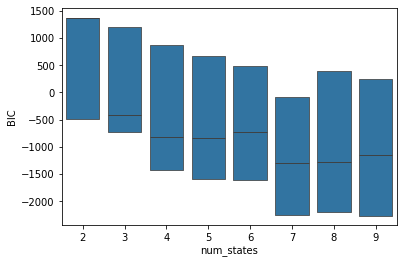

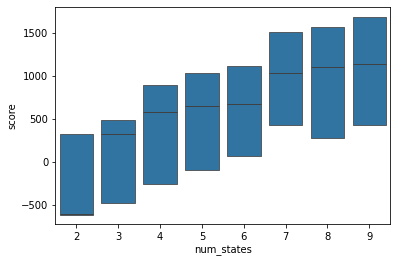

<Figure size 432x288 with 0 Axes>

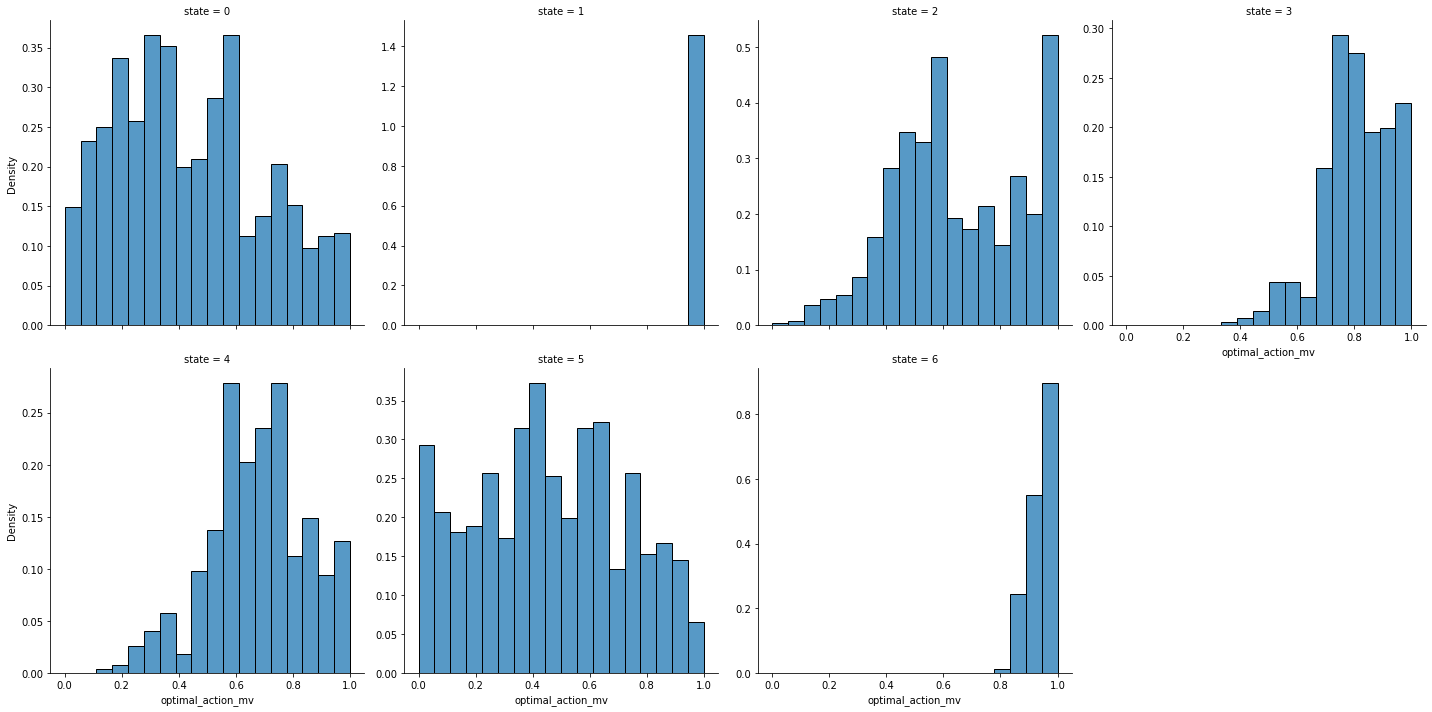

<Figure size 432x288 with 0 Axes>

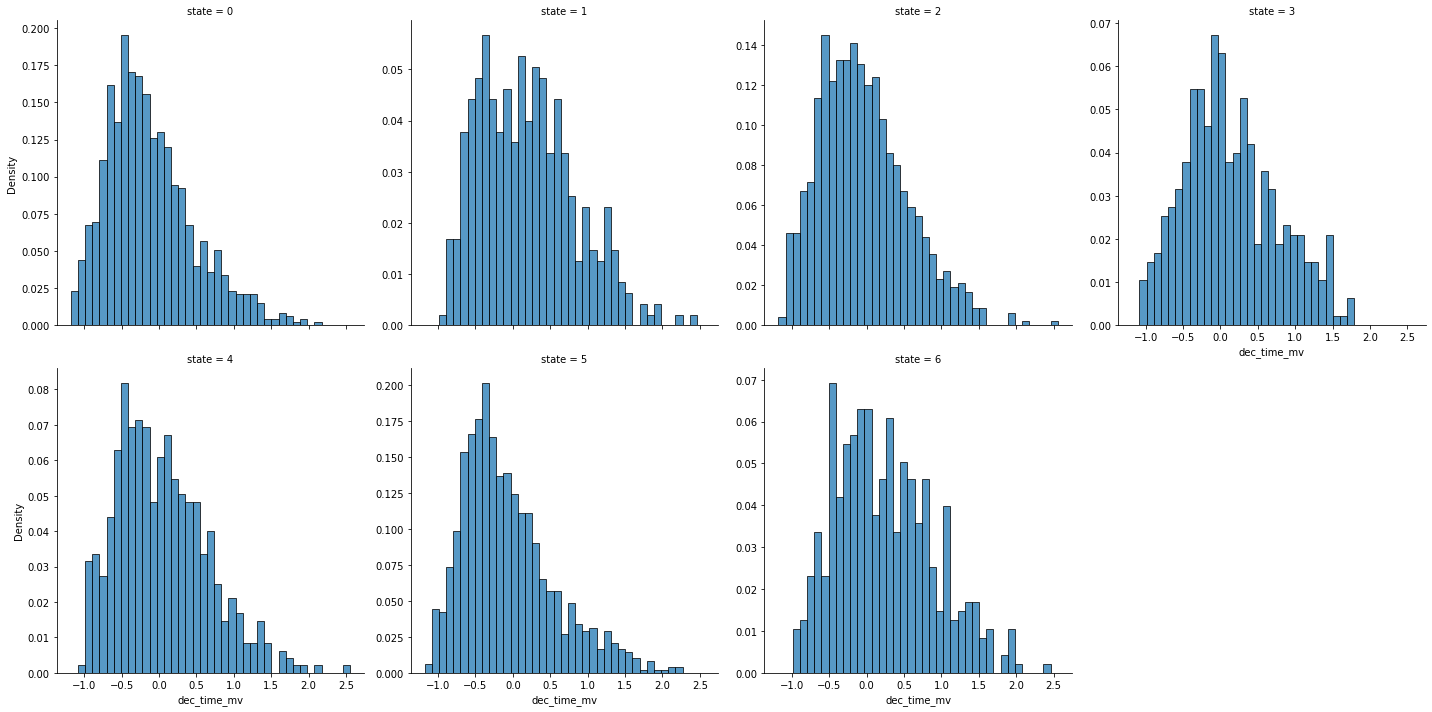

<Figure size 432x288 with 0 Axes>

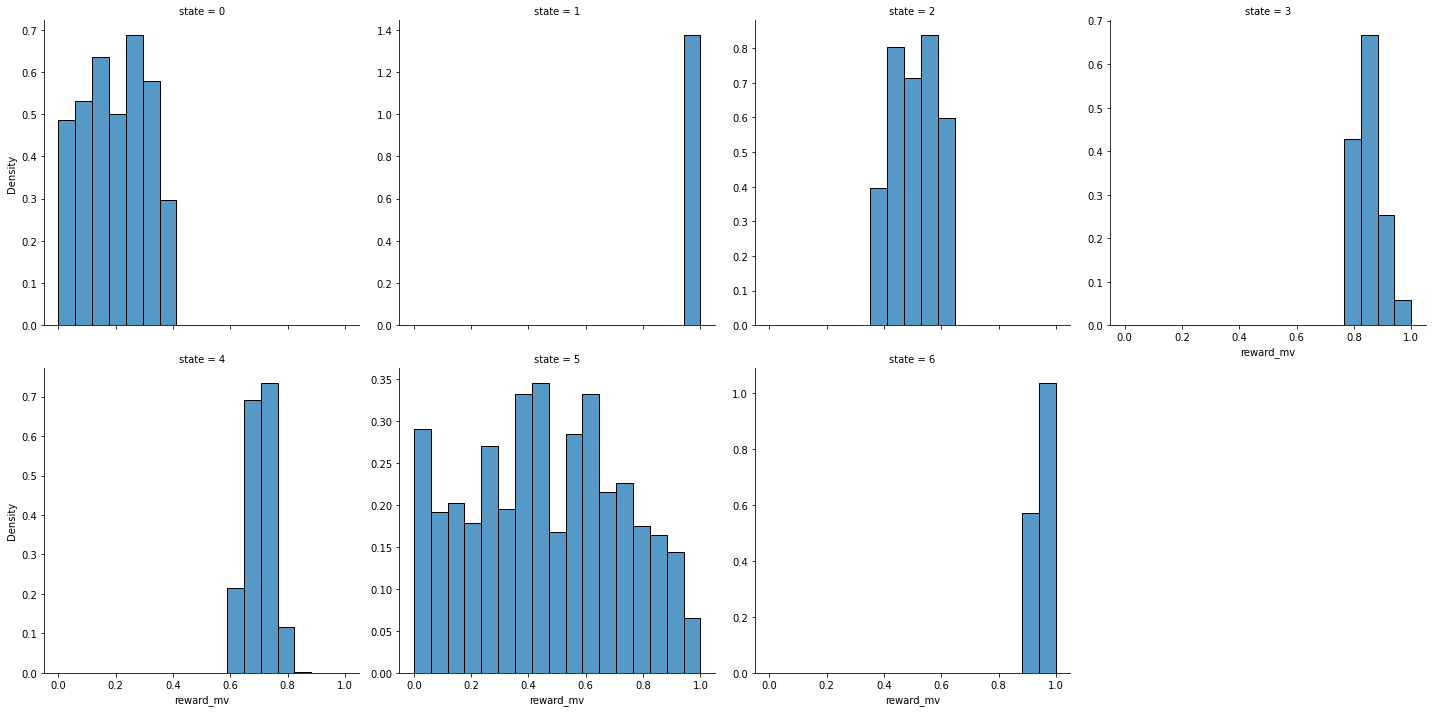

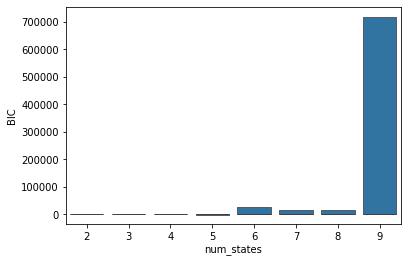

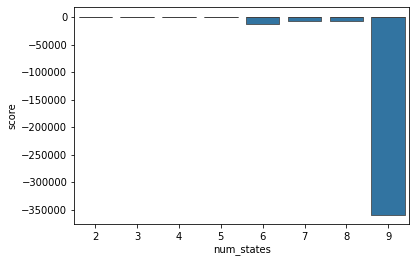

<Figure size 432x288 with 0 Axes>

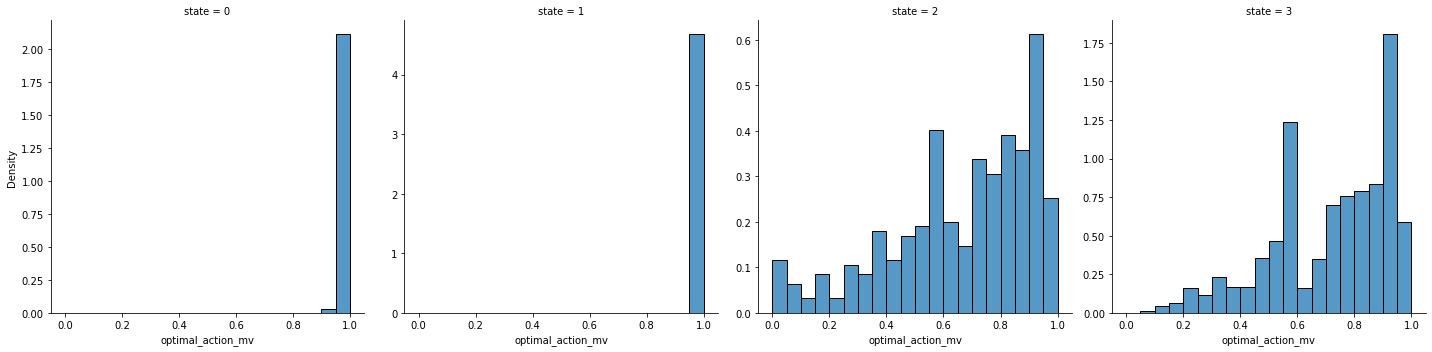

<Figure size 432x288 with 0 Axes>

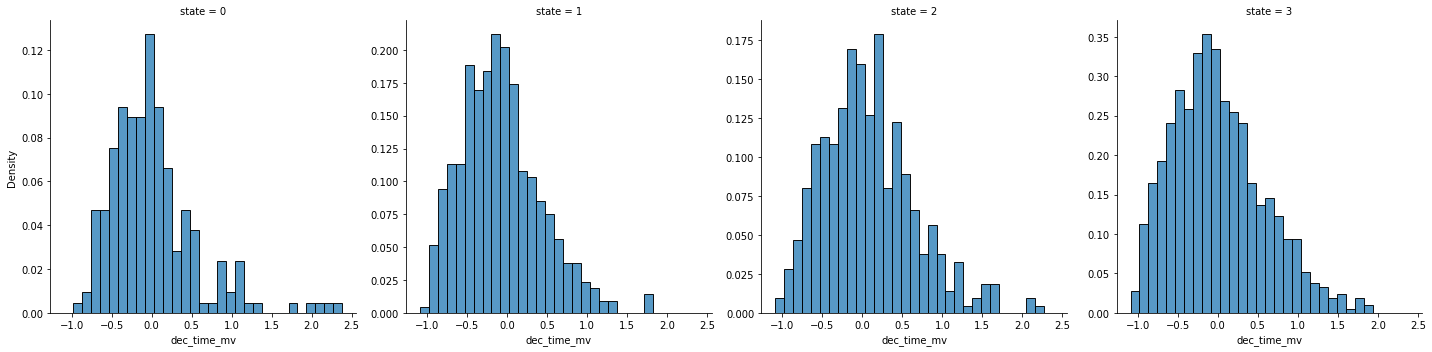

<Figure size 432x288 with 0 Axes>

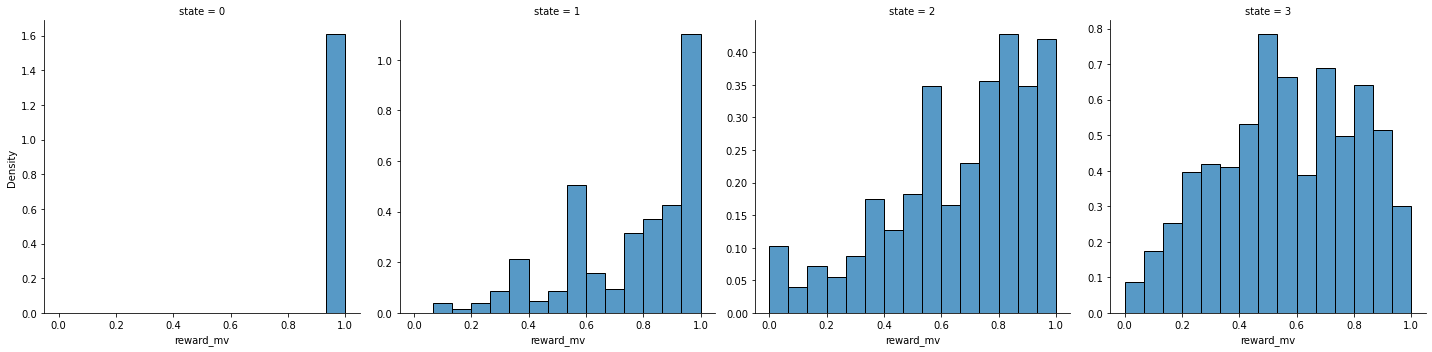

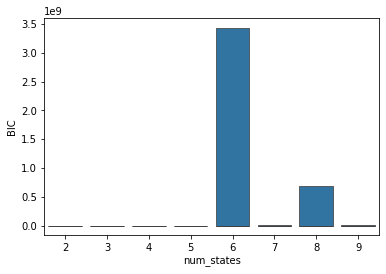

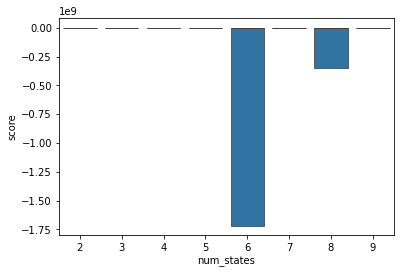

<Figure size 432x288 with 0 Axes>

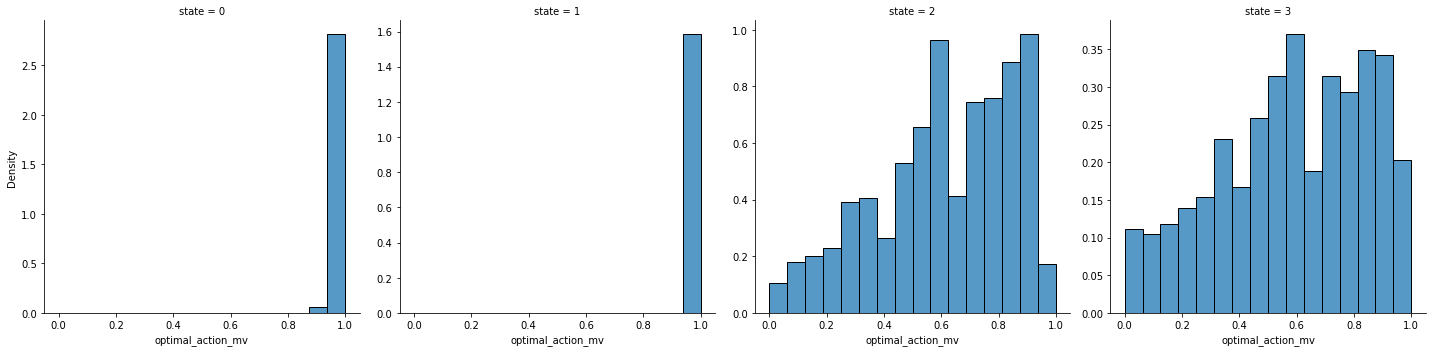

<Figure size 432x288 with 0 Axes>

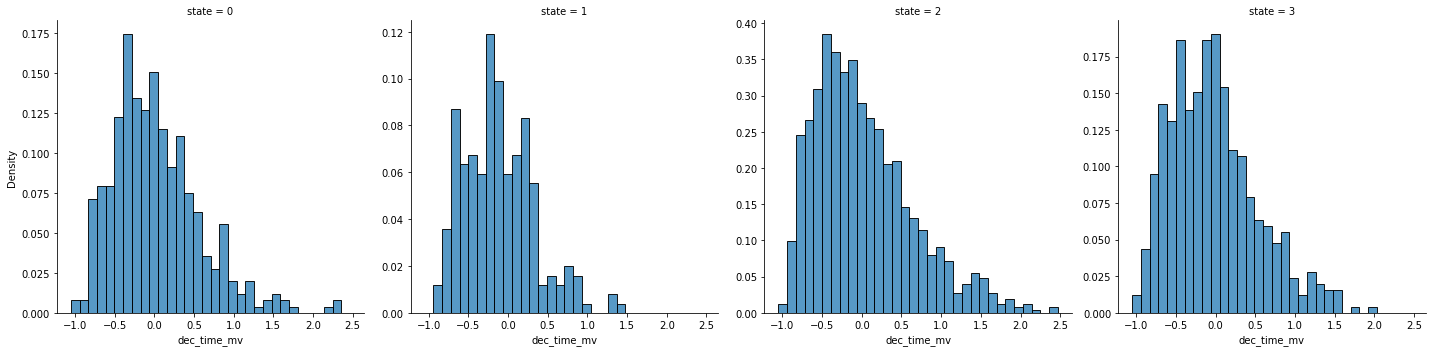

<Figure size 432x288 with 0 Axes>

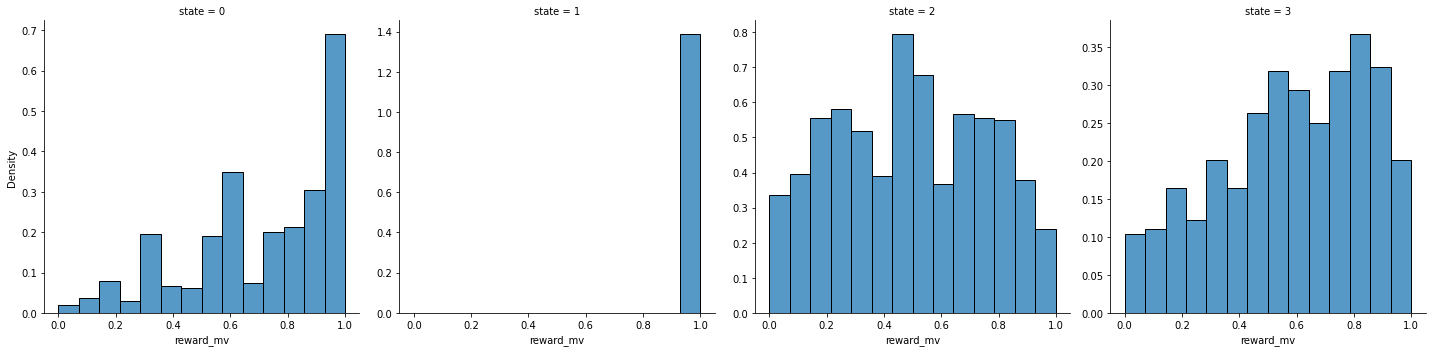

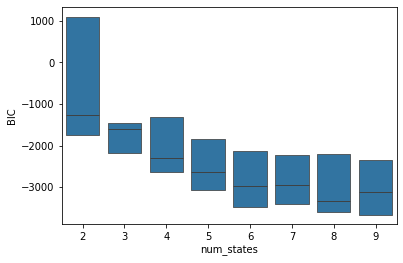

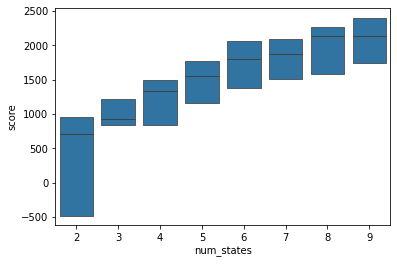

<Figure size 432x288 with 0 Axes>

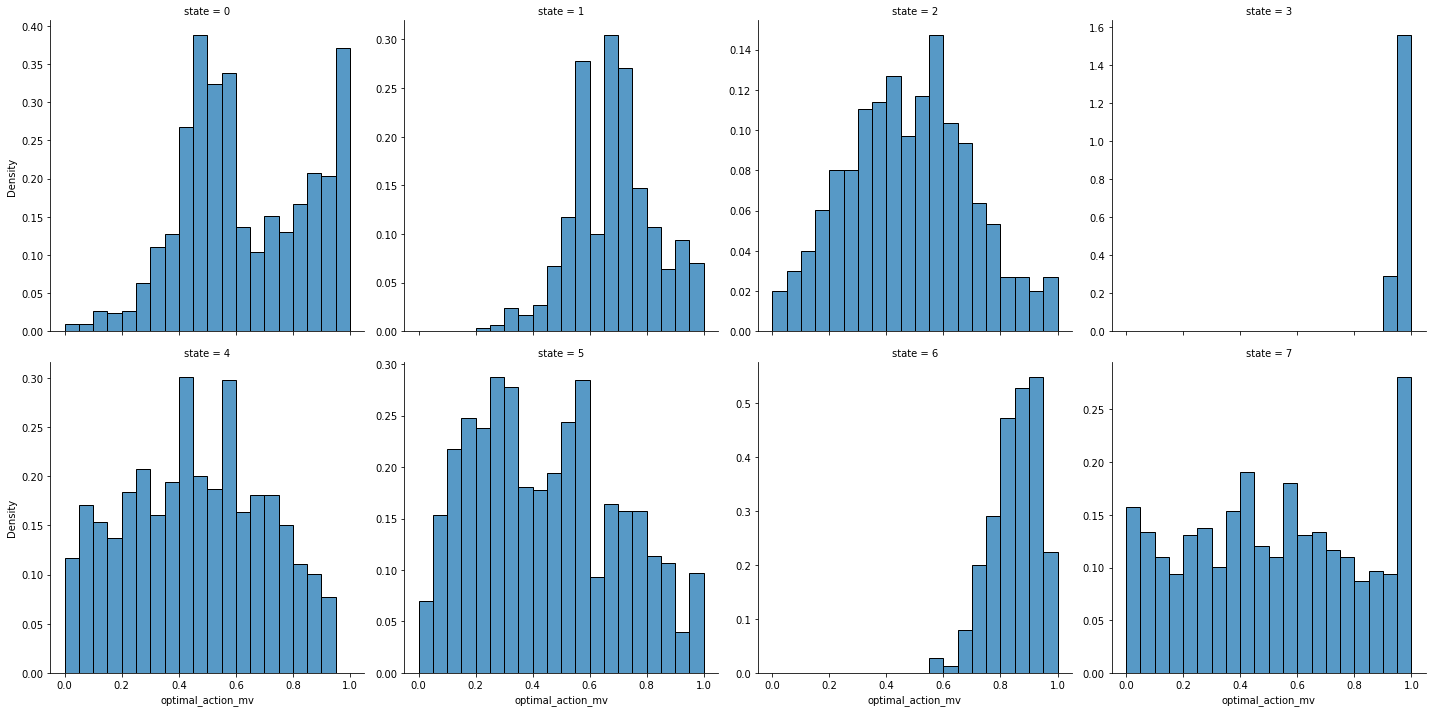

<Figure size 432x288 with 0 Axes>

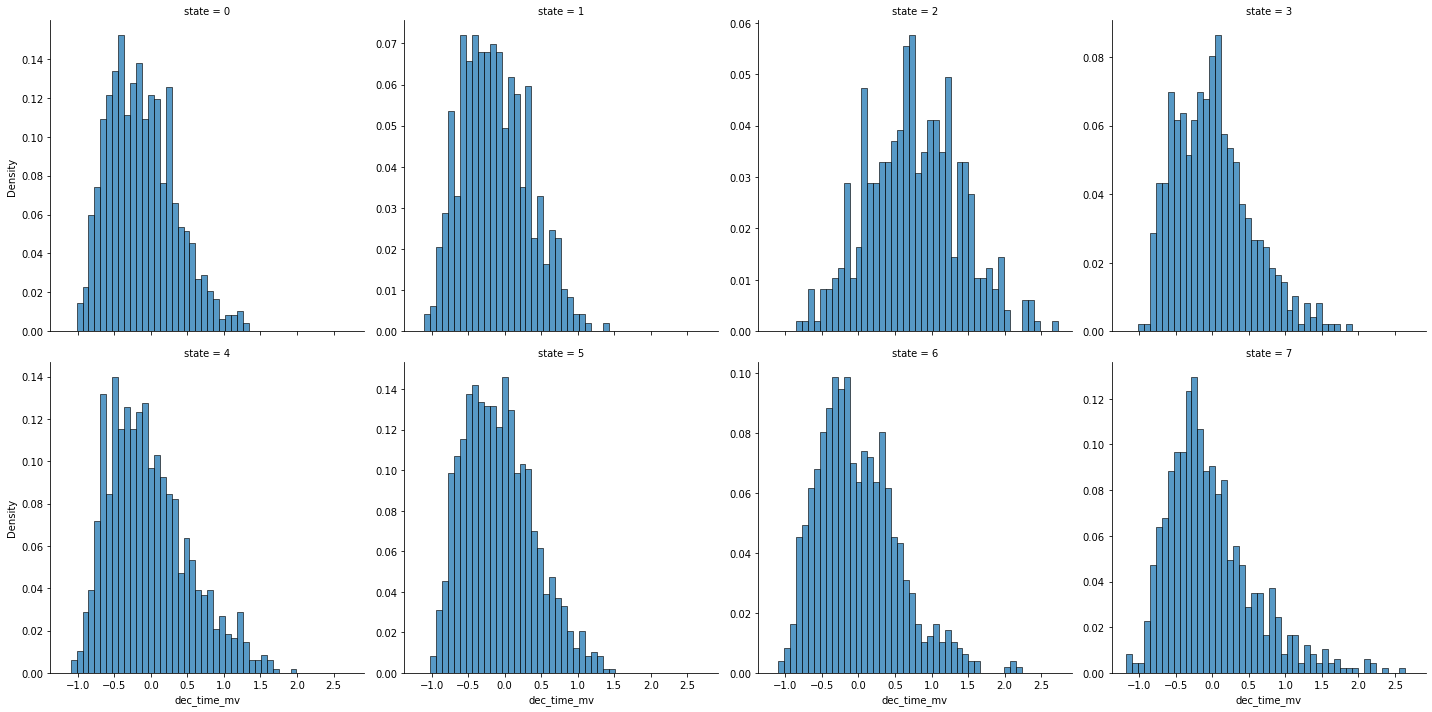

<Figure size 432x288 with 0 Axes>

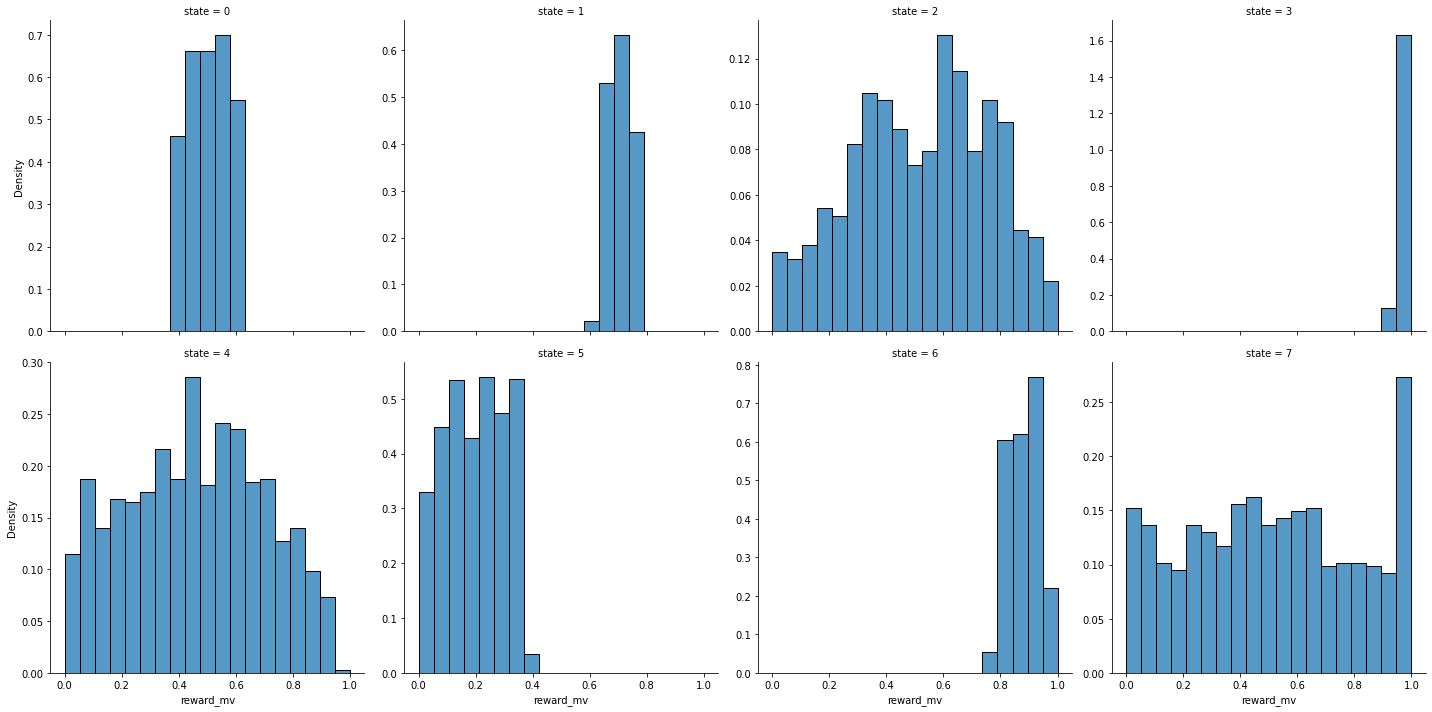

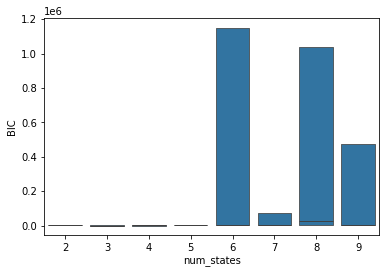

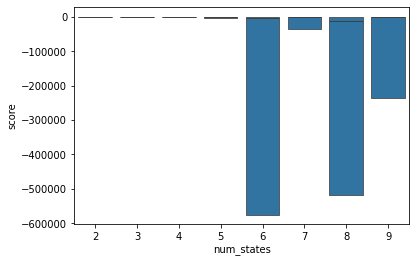

<Figure size 432x288 with 0 Axes>

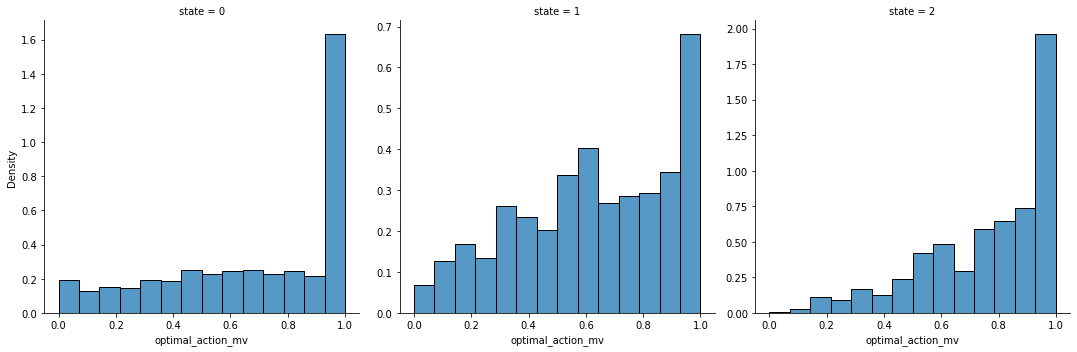

<Figure size 432x288 with 0 Axes>

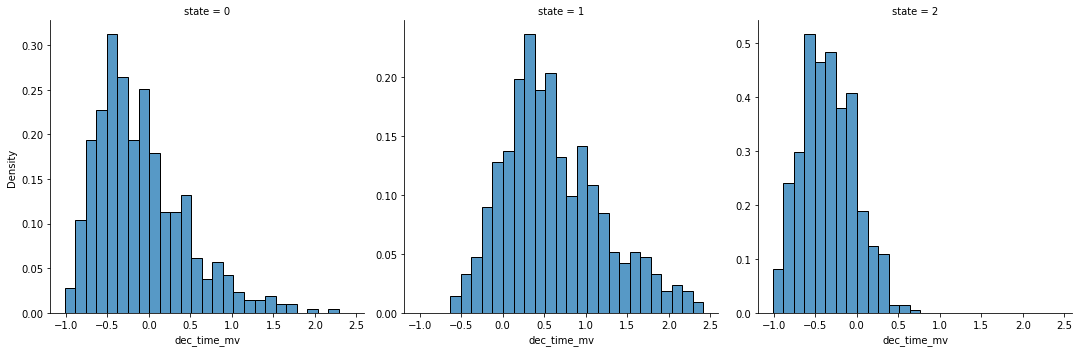

<Figure size 432x288 with 0 Axes>

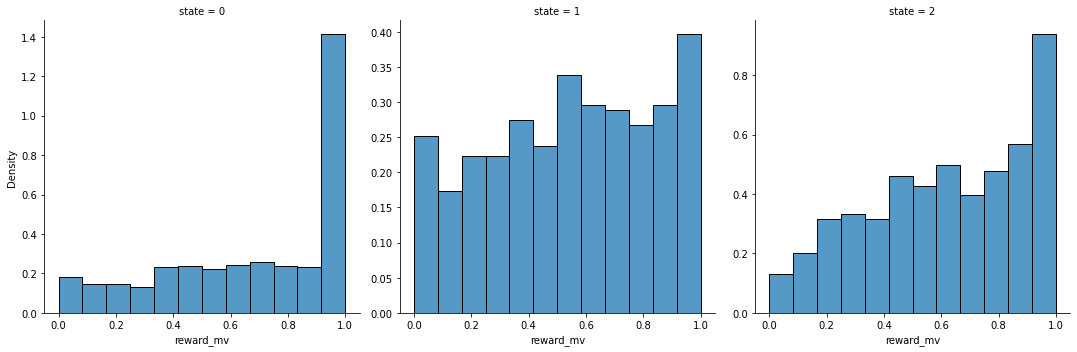

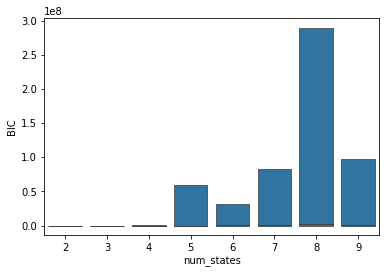

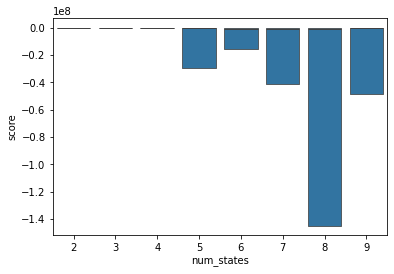

<Figure size 432x288 with 0 Axes>

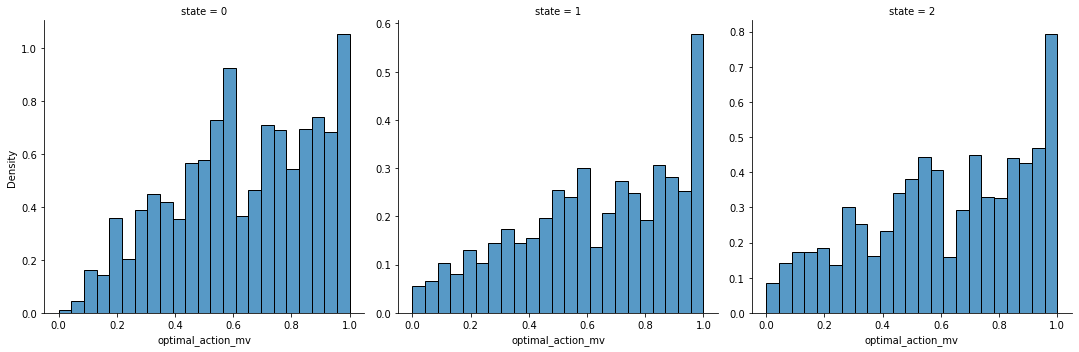

<Figure size 432x288 with 0 Axes>

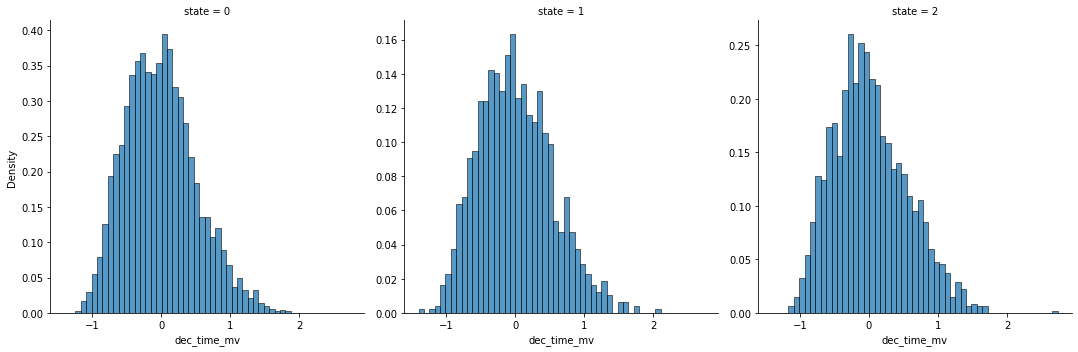

<Figure size 432x288 with 0 Axes>

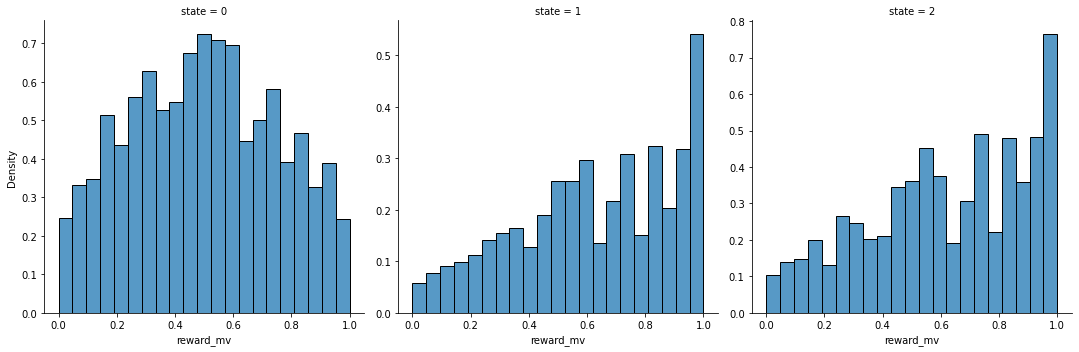

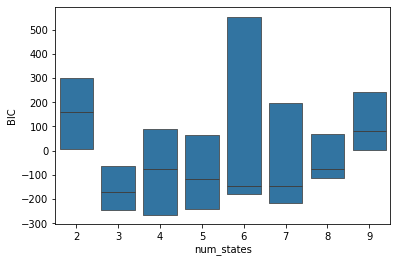

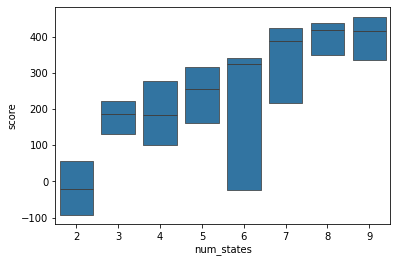

<Figure size 432x288 with 0 Axes>

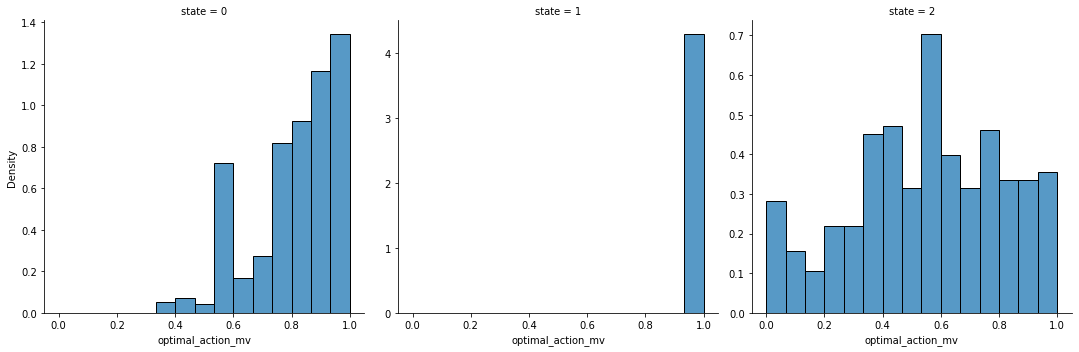

<Figure size 432x288 with 0 Axes>

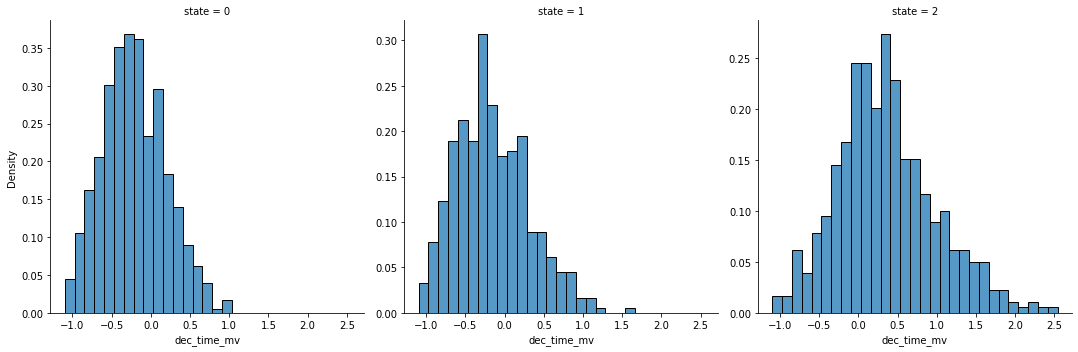

<Figure size 432x288 with 0 Axes>

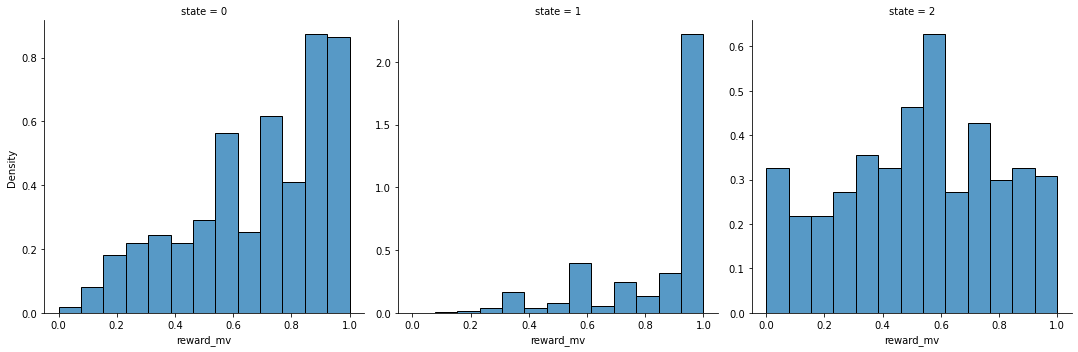

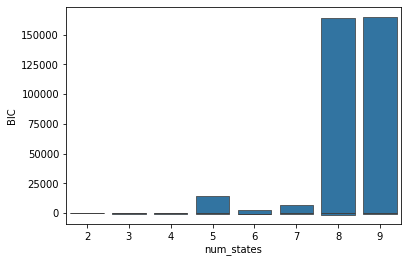

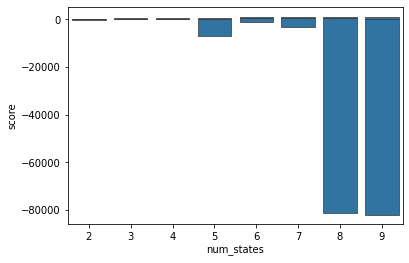

<Figure size 432x288 with 0 Axes>

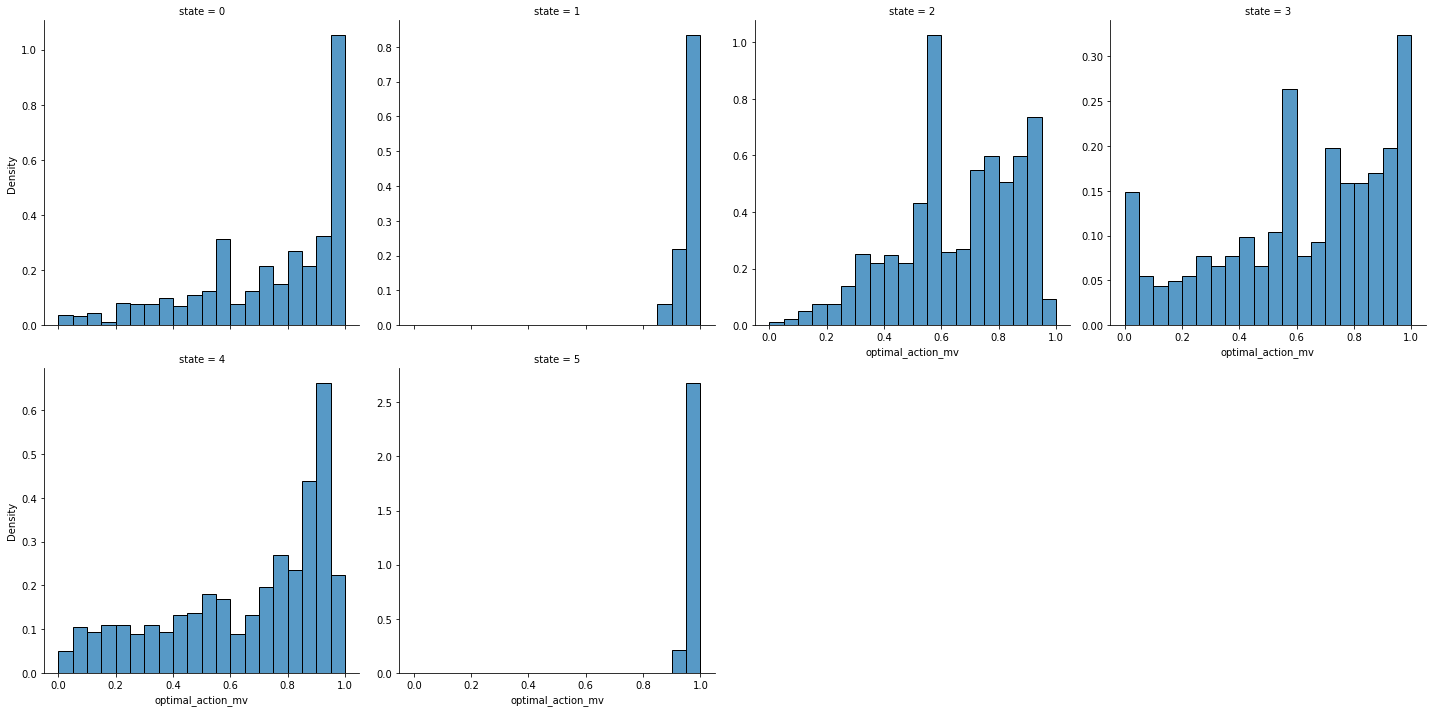

<Figure size 432x288 with 0 Axes>

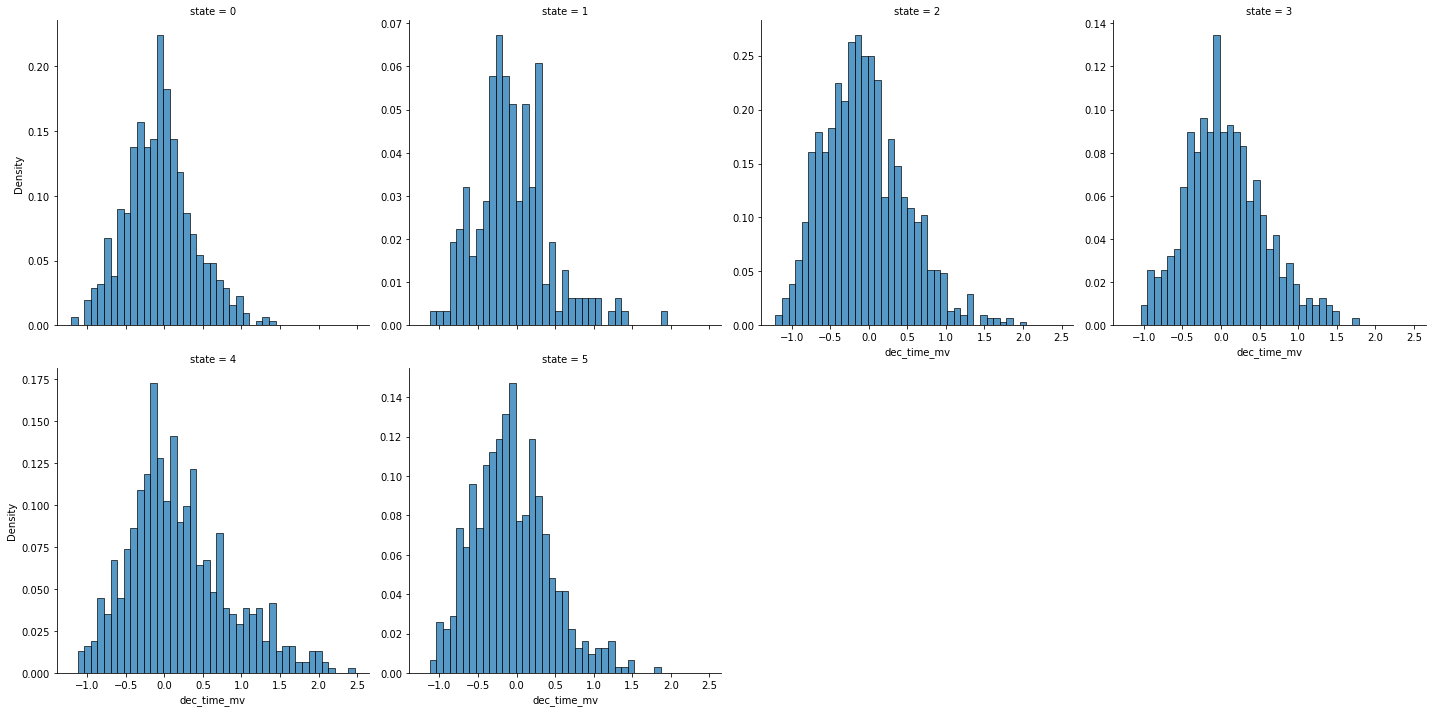

<Figure size 432x288 with 0 Axes>

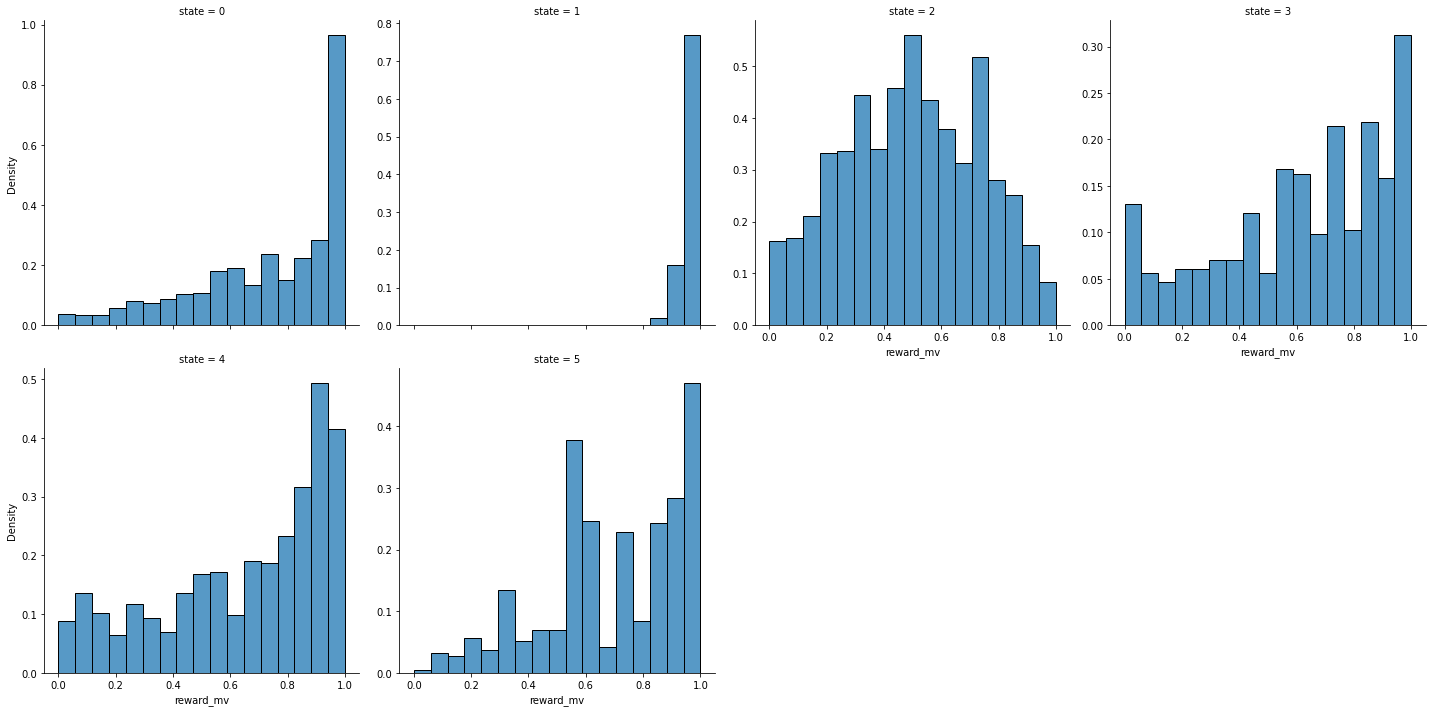

In [8]:


# For all mice 
for grp in No_conflict_low_volatility.groupby("animal_id"):
    print(grp[0])
#     if grp[0] in [1,2,4,5]:
#         continue
    mouse_indiv = grp[1].copy()
    mouse_indiv = mouse_indiv.rename({'RT(ms)': 'dec_time'}, axis=1)

    # Remove outliers
#     q1 = np.percentile(mouse_indiv.dec_time.values,25)
#     q3 = np.percentile(mouse_indiv.dec_time.values,75)
#     iqr = q3 - q1
#     low_limit = q1 - 1.5*iqr
#     high_limit = q3 + 1.5*iqr

    mouse_indiv_wo_outliers = remove_outliers(mouse_indiv)
    #mouse_indiv.loc[(mouse_indiv['dec_time']>low_limit)&(mouse_indiv['dec_time']<high_limit)]
    
    # Z-score 
    scale = StandardScaler()
    mouse_indiv_wo_outliers["dec_time_robust_scaled"] =scale.fit_transform(mouse_indiv_wo_outliers.dec_time.values.reshape(-1,1))

    block_change, dec_times, optimal_action = concatenate_all_sessions(mouse_indiv_wo_outliers)
    
    mouse_indiv_wo_outliers['optimal_action'] = optimal_action
    mouse_indiv_wo_outliers['block_change'] = block_change
    mouse_indiv_wo_outliers['dec_time'] = dec_times
    mouse_indiv_wo_outliers[['chosen_action', 'optimal_action', 'block', 'block_change', 'rewarded_code', 'dec_time']]    

    # removing all the first trials of a session

    mouse_indiv_wo_outliers = mouse_indiv_wo_outliers.loc[mouse_indiv_wo_outliers['optimal_action'] != -1]

    # calculating exponentially weighted moving averages for optimal action and reward, across a span of 4 trials
    optimal_action_mv, reward_mv, dec_times_mv = calculate_moving_average(mouse_indiv_wo_outliers)
    mouse_indiv_wo_outliers['optimal_action_mv'] = optimal_action_mv
    mouse_indiv_wo_outliers['reward_mv'] = reward_mv
    mouse_indiv_wo_outliers['dec_time_mv'] = dec_times_mv
    

    full_data = mouse_indiv_wo_outliers[["dec_time_mv", "optimal_action_mv", "reward_mv"]].to_numpy()
    action_copy = np.copy(full_data)
    kf = KFold(n_splits=folds)

#     np.random.shuffle(action_copy)

    bic_df, score_df = find_ideal_states(action_copy,num_c_array)
    plt.figure()
    g4 = sns.boxenplot(x="num_states",y="BIC",data=bic_df,showfliers=False)
    g4.figure.savefig("../../Figures/states_vs_BIC_"+str(grp[0])+".png")
    plt.figure()
    g5 = sns.boxenplot(x="num_states",y="score",data=score_df,showfliers=False)
    g5.figure.savefig("../../Figures/states_vs_score_"+str(grp[0])+".png")
    
    bic_df.to_csv(data_dir+"bic_df_"+str(grp[0])+".csv")
    score_df.to_csv(data_dir+"score_df_"+str(grp[0])+".csv")
    
    # If similar BIC values, choose the one with higher number of states
    calc_bic = bic_df.groupby('num_states')['BIC'].mean().reset_index()
    calc_score = score_df.groupby('num_states')['score'].mean().reset_index()
    
    test =  calc_bic.loc[np.abs(calc_bic['BIC'] - calc_bic['BIC'].min())<0.5].copy()
    if len(test) > 1:
        best_com = test['num_states'].max()
    else:
        calc_bic = bic_df.groupby('num_states')['BIC'].median().reset_index()
        print("calc_bic")
        best_com = calc_bic.loc[calc_bic["BIC"]==calc_bic["BIC"].min()]["num_states"].values[0]

    # Fitting the model with components that gave the lowest BIC
    
    best_model = GaussianHMM(covariance_type='full', n_components=best_com,tol=0.001,n_iter=300 )#params='ste', init_params='ste')
    best_model.fit(full_data)
    print(f"Means: {best_model.means_}")
    
    model_means = pd.DataFrame()
    model_means["decision_time"] = best_model.means_[:,0]
    # If previous trial was rewarded and mouse stayed ==> optimal
    # If previous trial was unrewarded and mouse switched ==> optimal
    model_means["probability_optimal_action"] = best_model.means_[:,1]
    model_means["probability_reward"] = best_model.means_[:,2]
    model_means["state_num"] = np.arange(0,len(best_mode.means_))
    model_means["animal_id"] = grp[0]
    
    model_means.to_csv(data_dir+"model_means_"+str(grp[0])+".csv")
    
    real_states = best_model.predict(full_data)#.reshape(-1, 1))
    mouse_indiv_wo_outliers["state"] = real_states    
    
    mouse_indiv_wo_outliers.to_csv(data_dir+"mouse_data_with_states_"+str(grp[0])+".csv")
    pickle.dump(best_model,open(data_dir+"HMM_model_"+str(grp[0])+".pickle","wb"))

    
    
    plt.figure()
    # Plotting 
    g1 = sns.displot(data=mouse_indiv_wo_outliers, x='optimal_action_mv', col='state', 
                    facet_kws=dict(sharey=False, sharex=True),
                    stat='density',col_wrap=4)
#     for ax in g1.axes:
#         tit = ax.get_title().split(' = ')[1]
        
#         ax.axvline(x=data['mean'], c='k', ls='--', lw=2.5)
    g1.savefig(fig_dir+"state_wise_optimal_action_"+str(grp[0])+".png")

    plt.figure()
    g2 = sns.displot(data=mouse_indiv_wo_outliers, x='dec_time_mv', col='state', 
                    facet_kws=dict(sharey=False, sharex=True),
                    stat='density',col_wrap=4)
    g2.savefig(fig_dir+"state_wise_decision_time_"+str(grp[0])+".png")
    
    plt.figure()
    g3 = sns.displot(data=mouse_indiv_wo_outliers, x='reward_mv', col='state', 
                    facet_kws=dict(sharey=False, sharex=True),
                    stat='density',col_wrap=4)
    g3.savefig(fig_dir+"state_wise_reward_"+str(grp[0])+".png")
    
    

    
    

In [9]:
grp[0]

9

In [10]:
calc_bic

,num_states,BIC
0,2,70.188749
1,3,-310.566540
2,4,-373.150010
3,5,380.644519
4,6,-484.666816
5,7,-325.136547
6,8,-133.119926
7,9,331.178265


In [11]:
calc_score

,num_states,score
0,2,34.118200
1,3,270.637560
2,4,354.662685
3,5,37.090484
4,6,535.662889
5,7,528.406166
6,8,511.497940
7,9,365.040603


In [ ]:
np.random.choice(np.arange(1,9999999),2)

In [ ]:
#     pickle.dump(best_model,open(data_dir+"HMM_model_"+str(grp[0])+".csv","wb"))
    
    # Plotting 
# g1 = sns.displot(data=mouse_indiv_wo_outliers, x='optimal_action_mv', col='state', 
#                 facet_kws=dict(sharey=False, sharex=True),
#                 stat='density')
# g1.savefig(fig_dir+"state_wise_optimal_action_"+str(grp[0])+".png")

# g2 = sns.displot(data=mouse_indiv_wo_outliers, x='dec_time_mv', col='state', 
#                 facet_kws=dict(sharey=False, sharex=True),
#                 stat='density')
# g2.savefig(fig_dir+"state_wise_decision_time_"+str(grp[0])+".png")

# g3 = sns.displot(data=mouse_indiv_wo_outliers, x='reward_mv', col='state', 
#                 facet_kws=dict(sharey=False, sharex=True),
#                 stat='density')
# g3.savefig(fig_dir+"state_wise_reward_"+str(grp[0])+".png")

In [ ]:
grp[0]